# (1) Import Modules and Load Data

In [142]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [143]:
eu = pd.read_csv('EURUSD.csv')
gu = pd.read_csv('GBPUSD.csv')
uc = pd.read_csv('USDCHF.csv')
uj = pd.read_csv('USDJPY.csv')

#remove samples which have no volume (typically during weekend)
eu = eu[eu.Volume!=0]
gu = gu[gu.Volume!=0]
uc = uc[uc.Volume!=0]
uj = uj[uj.Volume!=0]

#convert time column to datetime object
eu['Gmt time'] = pd.to_datetime(eu['Gmt time'],format="%d.%m.%Y %H:%M:%S.%f")
gu['Gmt time'] = pd.to_datetime(gu['Gmt time'],format="%d.%m.%Y %H:%M:%S.%f")
uc['Gmt time'] = pd.to_datetime(uc['Gmt time'],format="%d.%m.%Y %H:%M:%S.%f")
uj['Gmt time'] = pd.to_datetime(uj['Gmt time'],format="%d.%m.%Y %H:%M:%S.%f")

# (2) Define Strategy Functions

In [144]:
def bollinger_strat(df, bollinger_period=20, thres=2, cap=10000):
    
    #df: input DataFrame
    #bollinger_period: number of historical periods used in determining bollinger bands
    #thres: number of standard deviations used in determining bollinger bands
    #cap: initial capitalization in the investment
    
    #determine price changes and bollinger bands
    df['price_change'] = df.Open-df.Open.shift(1)
    df[str(bollinger_period)+'_ma'] = df.Close.rolling(window=bollinger_period).mean()
    df['lower_bollinger_band'] = df[str(bollinger_period)+'_ma']-thres*df.Close.rolling(window=bollinger_period).std(ddof=0)
    df['upper_bollinger_band'] = df[str(bollinger_period)+'_ma']+thres*df.Close.rolling(window=bollinger_period).std(ddof=0)
    df = df.dropna()
    
    #create variables for storing intermediate and final information
    below_or_above = np.zeros(len(df))
    holding = np.zeros(len(df))
    action = np.zeros(len(df))
    units = np.zeros(len(df))
    strat_gain = np.zeros(len(df))
    strat_value = np.zeros(len(df))
    strat_daily_ret = np.zeros(len(df))
    strat_cum_ret = np.zeros(len(df))
    strat_drawdown = np.zeros(len(df))
    strat_max_drawdown = np.zeros(len(df))
    fx_units = cap/df.iloc[1,1]
    fx_gain = np.zeros(len(df))
    fx_value = np.zeros(len(df))
    fx_daily_ret = np.zeros(len(df))
    fx_cum_ret = np.zeros(len(df))
    fx_drawdown = np.zeros(len(df))
    fx_max_drawdown = np.zeros(len(df))
    strat_value[0] = cap
    fx_value[0] = cap
    
    #loop over each day to fill in respective values
    for i in range(1,len(df)):
        
        #determine the position of current open in regards of bollinger bands as of previous close
        if df.iloc[i,1] < df.iloc[i-1,8]:
            below_or_above[i] = 1
        elif df.iloc[i,1] > df.iloc[i-1,9]:
            below_or_above[i] = -1
            
        #update long/short action based on trading signal
        if holding[i-1]==0 and below_or_above[i-1]==1 and below_or_above[i]==0:
            action[i] = 1
        elif holding[i-1]==0 and below_or_above[i-1]==-1 and below_or_above[i]==0:
            action[i] = -1
        elif holding[i-1]==1 and below_or_above[i-1]==-1 and below_or_above[i]==0:
            action[i] = -2
        elif holding[i-1]==-1 and below_or_above[i-1]==1 and below_or_above[i]==0:
            action[i] = 2
        
        #update holding position
        holding[i] = holding[i-1]+action[i]
        
        #calculate number of units in the holding
        if action[i]!=0:
            units[i] = strat_value[i-1]/df.iloc[i,1]
        else:
            units[i] = units[i-1]
            
        #calculate strategy daily gain, total value, daily return, and cumulative return
        strat_gain[i] = df.iloc[i,6]*holding[i-1]*units[i-1]
        strat_value[i] = strat_value[i-1]+strat_gain[i]
        strat_daily_ret[i] = strat_gain[i]/strat_value[i-1]
        strat_cum_ret[i] = strat_value[i]/cap-1
        
        #calculate strategy drawdown and max drawdown at each time point
        if strat_cum_ret[i]<max(strat_cum_ret[:i+1]):
            strat_drawdown[i] = (1+strat_cum_ret[i])/(1+max(strat_cum_ret[:i+1]))-1
        strat_max_drawdown[i] = min(strat_drawdown[:i+1])
        
        #calculate performance of buy-hold strategy
        fx_gain[i] = fx_units*df.iloc[i,6]
        fx_value[i] = fx_value[i-1]+fx_gain[i]
        fx_daily_ret[i] = fx_gain[i]/fx_value[i-1]
        fx_cum_ret[i] = fx_value[i]/cap-1
        
        #calculate buy-hold strategy drawdown and max drawdown at each time point
        if fx_cum_ret[i]<max(fx_cum_ret[:i+1]):
            fx_drawdown[i] = (1+fx_cum_ret[i])/(1+max(fx_cum_ret[:i+1]))-1
        fx_max_drawdown[i] = min(fx_drawdown[:i+1])
   
    df['below_or_above_bollinger'] = below_or_above
    df['holding'] = holding
    df['action'] = action
    df['units'] = units
    df['strat_gain'] = strat_gain
    df['strat_value'] = strat_value
    df['strat_daily_ret'] = strat_daily_ret
    df['strat_cum_ret'] = strat_cum_ret
    df['strat_drawdown'] = strat_drawdown
    df['strat_max_drawdown'] = strat_max_drawdown
    df['fx_gain'] = fx_gain
    df['fx_value'] = fx_value
    df['fx_daily_ret'] = fx_daily_ret
    df['fx_cum_ret'] = fx_cum_ret
    df['fx_drawdown'] = fx_drawdown
    df['fx_max_drawdown'] = fx_max_drawdown
    
    return df

In [145]:
def bollinger_strat_trend_filter(df, bollinger_period=20, short_ma=100, long_ma=200, thres=2, cap=10000):
    
    #df: input DataFrame
    #bollinger_period: number of historical periods used in determining bollinger bands
    #thres: number of standard deviations used in determining bollinger bands
    #cap: initial capitalization in the investment
    
    #determine price changes and bollinger bands
    df['price_change'] = df.Open-df.Open.shift(1)
    df[str(bollinger_period)+'_ma'] = df.Close.rolling(window=bollinger_period).mean()
    df['lower_bollinger_band'] = df[str(bollinger_period)+'_ma']-thres*df.Close.rolling(window=bollinger_period).std(ddof=0)
    df['upper_bollinger_band'] = df[str(bollinger_period)+'_ma']+thres*df.Close.rolling(window=bollinger_period).std(ddof=0)
    df[str(short_ma)+'_ma'] = df.Close.rolling(window=short_ma).mean()
    df[str(long_ma)+'_ma'] = df.Close.rolling(window=long_ma).mean()
    df = df.dropna()
    
    #create variables for storing intermediate and final information
    below_or_above = np.zeros(len(df))
    golden_or_death = np.zeros(len(df))
    holding = np.zeros(len(df))
    action = np.zeros(len(df))
    units = np.zeros(len(df))
    strat_gain = np.zeros(len(df))
    strat_value = np.zeros(len(df))
    strat_daily_ret = np.zeros(len(df))
    strat_cum_ret = np.zeros(len(df))
    strat_drawdown = np.zeros(len(df))
    strat_max_drawdown = np.zeros(len(df))
    fx_units = cap/df.iloc[1,1]
    fx_gain = np.zeros(len(df))
    fx_value = np.zeros(len(df))
    fx_daily_ret = np.zeros(len(df))
    fx_cum_ret = np.zeros(len(df))
    fx_drawdown = np.zeros(len(df))
    fx_max_drawdown = np.zeros(len(df))
    strat_value[0] = cap
    fx_value[0] = cap
    
    #loop over each day to fill in respective values
    for i in range(1,len(df)):
        
        #determine the position of current open in regards of bollinger bands as of previous close
        if df.iloc[i,1] < df.iloc[i-1,8]:
            below_or_above[i] = 1
        elif df.iloc[i,1] > df.iloc[i-1,9]:
            below_or_above[i] = -1
            
        #determine whether short_ma is larger than long_ma
        if df.iloc[i-1,10] >= df.iloc[i-1,11]:
            golden_or_death[i] = 1
        else:
            golden_or_death[i] = -1
            
        #update long/short action based on trading signal
        if holding[i-1]==0 and below_or_above[i-1]==1 and below_or_above[i]==0 and golden_or_death[i]==1:
            action[i] = 1
        elif holding[i-1]==0 and below_or_above[i-1]==-1 and below_or_above[i]==0 and golden_or_death[i]==-1:
            action[i] = -1
        elif holding[i-1]==1 and below_or_above[i-1]==-1 and below_or_above[i]==0 and golden_or_death[i]==-1:
            action[i] = -2
        elif holding[i-1]==-1 and below_or_above[i-1]==1 and below_or_above[i]==0 and golden_or_death[i]==1:
            action[i] = 2
        
        #update holding position
        holding[i] = holding[i-1]+action[i]
        
        #calculate number of units in the holding
        if action[i]!=0:
            units[i] = strat_value[i-1]/df.iloc[i,1]
        else:
            units[i] = units[i-1]
            
        #calculate strategy daily gain, total value, daily return, and cumulative return
        strat_gain[i] = df.iloc[i,6]*holding[i-1]*units[i-1]
        strat_value[i] = strat_value[i-1]+strat_gain[i]
        strat_daily_ret[i] = strat_gain[i]/strat_value[i-1]
        strat_cum_ret[i] = strat_value[i]/cap-1
        
        #calculate strategy drawdown and max drawdown at each time point
        if strat_cum_ret[i]<max(strat_cum_ret[:i+1]):
            strat_drawdown[i] = (1+strat_cum_ret[i])/(1+max(strat_cum_ret[:i+1]))-1
        strat_max_drawdown[i] = min(strat_drawdown[:i+1])
        
        #calculate performance of buy-hold strategy
        fx_gain[i] = fx_units*df.iloc[i,6]
        fx_value[i] = fx_value[i-1]+fx_gain[i]
        fx_daily_ret[i] = fx_gain[i]/fx_value[i-1]
        fx_cum_ret[i] = fx_value[i]/cap-1
        
        #calculate buy-hold strategy drawdown and max drawdown at each time point
        if fx_cum_ret[i]<max(fx_cum_ret[:i+1]):
            fx_drawdown[i] = (1+fx_cum_ret[i])/(1+max(fx_cum_ret[:i+1]))-1
        fx_max_drawdown[i] = min(fx_drawdown[:i+1])
   
    df['below_or_above_bollinger'] = below_or_above
    df['golden_or_death'] = golden_or_death
    df['holding'] = holding
    df['action'] = action
    df['units'] = units
    df['strat_gain'] = strat_gain
    df['strat_value'] = strat_value
    df['strat_daily_ret'] = strat_daily_ret
    df['strat_cum_ret'] = strat_cum_ret
    df['strat_drawdown'] = strat_drawdown
    df['strat_max_drawdown'] = strat_max_drawdown
    df['fx_gain'] = fx_gain
    df['fx_value'] = fx_value
    df['fx_daily_ret'] = fx_daily_ret
    df['fx_cum_ret'] = fx_cum_ret
    df['fx_drawdown'] = fx_drawdown
    df['fx_max_drawdown'] = fx_max_drawdown
    
    return df

# (3) Using Training Data to Optimize Parameters

**Note:** For backtesting purpose, we assume the initial capitalization is 10000CHF (10000JPY) in USDCHF (USDJPY) trading so that we don't need to convert back and forth

In [146]:
#train-test split
eu_train1 = eu[eu['Gmt time']<'2011-01-01']
eu_test1 = eu[eu['Gmt time']>='2011-01-01']
eu_train2 = eu_train1.copy()
eu_test2 = eu_test1.copy()
gu_train1 = gu[gu['Gmt time']<'2011-01-01']
gu_test1 = gu[gu['Gmt time']>='2011-01-01']
gu_train2 = gu_train1.copy()
gu_test2 = gu_test1.copy()
uc_train1 = uc[uc['Gmt time']<'2011-01-01']
uc_test1 = uc[uc['Gmt time']>='2011-01-01']
uc_train2 = uc_train1.copy()
uc_test2 = uc_test1.copy()
uj_train1 = uj[uj['Gmt time']<'2011-01-01']
uj_test1 = uj[uj['Gmt time']>='2011-01-01']
uj_train2 = uj_train1.copy()
uj_test2 = uj_test1.copy()

#specify parameter range
bollinger_range = [10, 15, 20, 25, 30]
std_range = [1.5, 2, 2.5]
short_ma_range = [75, 100, 125]
long_ma_range = [175, 200, 225]

### EURUSD Bollinger Strategy w/o Trend Filter on Training Data

In [147]:
#run strategy with different parameters
eu_sharpe1 = []
eu_parameter1 = []
for i in bollinger_range:
    for j in std_range:
        table = bollinger_strat(eu_train1, bollinger_period=i, thres=j)
        eu_sharpe1.append(((1+table['strat_cum_ret'].values[-1])**(6240/(len(table)-1))-1)/(np.std(table['strat_daily_ret'])*np.sqrt(6240)))
        eu_parameter1.append((i,j))
        
#filter out parameters making the highest Sharpe Ratio
print('Highest Sharpe Ratio is',max(eu_sharpe1))
print('Corresponding parameters are',eu_parameter1[eu_sharpe1.index(max(eu_sharpe1))])

Highest Sharpe Ratio is 4.142833628642274
Corresponding parameters are (10, 2.5)


### EURUSD Bollinger Strategy with Trend Filter on Training Data

In [148]:
#run strategy with different parameters
eu_sharpe2 = []
eu_parameter2 = []
for i in bollinger_range:
    for j in short_ma_range:
        for k in long_ma_range:
            for m in std_range:
                table = bollinger_strat_trend_filter(eu_train2, bollinger_period=i, short_ma=j, long_ma=k, thres=m)
                eu_sharpe2.append(((1+table['strat_cum_ret'].values[-1])**(6240/(len(table)-1))-1)/(np.std(table['strat_daily_ret'])*np.sqrt(6240)))
                eu_parameter2.append((i,j,k,m))
        
#filter out parameters making the highest Sharpe Ratio
print('Highest Sharpe Ratio is',max(eu_sharpe2))
print('Corresponding parameters are',eu_parameter2[eu_sharpe2.index(max(eu_sharpe2))])

Highest Sharpe Ratio is 1.55725095896962
Corresponding parameters are (20, 75, 175, 2)


### GBPUSD Bollinger Strategy w/o Trend Filter on Training Data

In [152]:
#run strategy with different parameters
gu_sharpe1 = []
gu_parameter1 = []
for i in bollinger_range:
    for j in std_range:
        table = bollinger_strat(gu_train1, bollinger_period=i, thres=j)
        gu_sharpe1.append(((1+table['strat_cum_ret'].values[-1])**(6240/(len(table)-1))-1)/(np.std(table['strat_daily_ret'])*np.sqrt(6240)))
        gu_parameter1.append((i,j))
        
#filter out parameters making the highest Sharpe Ratio
print('Highest Sharpe Ratio is',max(gu_sharpe1))
print('Corresponding parameters are',gu_parameter1[gu_sharpe1.index(max(gu_sharpe1))])

Highest Sharpe Ratio is 3.8978004583211647
Corresponding parameters are (15, 2)


### GBPUSD Bollinger Strategy with Trend Filter on Training Data

In [153]:
#run strategy with different parameters
gu_sharpe2 = []
gu_parameter2 = []
for i in bollinger_range:
    for j in short_ma_range:
        for k in long_ma_range:
            for m in std_range:
                table = bollinger_strat_trend_filter(gu_train2, bollinger_period=i, short_ma=j, long_ma=k, thres=m)
                gu_sharpe2.append(((1+table['strat_cum_ret'].values[-1])**(6240/(len(table)-1))-1)/(np.std(table['strat_daily_ret'])*np.sqrt(6240)))
                gu_parameter2.append((i,j,k,m))
        
#filter out parameters making the highest Sharpe Ratio
print('Highest Sharpe Ratio is',max(gu_sharpe2))
print('Corresponding parameters are',gu_parameter2[gu_sharpe2.index(max(gu_sharpe2))])

Highest Sharpe Ratio is 4.78667012071235
Corresponding parameters are (15, 75, 175, 2)


### USDCHF Bollinger Strategy w/o Trend Filter on Training Data

In [154]:
#run strategy with different parameters
uc_sharpe1 = []
uc_parameter1 = []
for i in bollinger_range:
    for j in std_range:
        table = bollinger_strat(uc_train1, bollinger_period=i, thres=j)
        uc_sharpe1.append(((1+table['strat_cum_ret'].values[-1])**(6240/(len(table)-1))-1)/(np.std(table['strat_daily_ret'])*np.sqrt(6240)))
        uc_parameter1.append((i,j))
        
#filter out parameters making the highest Sharpe Ratio
print('Highest Sharpe Ratio is',max(uc_sharpe1))
print('Corresponding parameters are',uc_parameter1[uc_sharpe1.index(max(uc_sharpe1))])

Highest Sharpe Ratio is 1.4585187966246975
Corresponding parameters are (10, 2)


### USDCHF Bollinger Strategy with Trend Filter on Training Data

In [155]:
#run strategy with different parameters
uc_sharpe2 = []
uc_parameter2 = []
for i in bollinger_range:
    for j in short_ma_range:
        for k in long_ma_range:
            for m in std_range:
                table = bollinger_strat_trend_filter(uc_train2, bollinger_period=i, short_ma=j, long_ma=k, thres=m)
                uc_sharpe2.append(((1+table['strat_cum_ret'].values[-1])**(6240/(len(table)-1))-1)/(np.std(table['strat_daily_ret'])*np.sqrt(6240)))
                uc_parameter2.append((i,j,k,m))
        
#filter out parameters making the highest Sharpe Ratio
print('Highest Sharpe Ratio is',max(uc_sharpe2))
print('Corresponding parameters are',uc_parameter2[uc_sharpe2.index(max(uc_sharpe2))])

Highest Sharpe Ratio is 4.940514833286273
Corresponding parameters are (10, 75, 200, 1.5)


### USDJPY Bollinger Strategy w/o Trend Filter on Training Data

In [156]:
#run strategy with different parameters
uj_sharpe1 = []
uj_parameter1 = []
for i in bollinger_range:
    for j in std_range:
        table = bollinger_strat(uj_train1, bollinger_period=i, thres=j)
        uj_sharpe1.append(((1+table['strat_cum_ret'].values[-1])**(6240/(len(table)-1))-1)/(np.std(table['strat_daily_ret'])*np.sqrt(6240)))
        uj_parameter1.append((i,j))
        
#filter out parameters making the highest Sharpe Ratio
print('Highest Sharpe Ratio is',max(uj_sharpe1))
print('Corresponding parameters are',uj_parameter1[uj_sharpe1.index(max(uj_sharpe1))])

Highest Sharpe Ratio is 5.1614396393654225
Corresponding parameters are (20, 2)


### USDJPY Bollinger Strategy with Trend Filter on Training Data

In [157]:
#run strategy with different parameters
uj_sharpe2 = []
uj_parameter2 = []
for i in bollinger_range:
    for j in short_ma_range:
        for k in long_ma_range:
            for m in std_range:
                table = bollinger_strat_trend_filter(uj_train2, bollinger_period=i, short_ma=j, long_ma=k, thres=m)
                uj_sharpe2.append(((1+table['strat_cum_ret'].values[-1])**(6240/(len(table)-1))-1)/(np.std(table['strat_daily_ret'])*np.sqrt(6240)))
                uj_parameter2.append((i,j,k,m))
        
#filter out parameters making the highest Sharpe Ratio
print('Highest Sharpe Ratio is',max(uj_sharpe2))
print('Corresponding parameters are',uj_parameter2[uj_sharpe2.index(max(uj_sharpe2))])

Highest Sharpe Ratio is 5.03688192354687
Corresponding parameters are (25, 75, 175, 1.5)


# (4) Testing Trading Strategies on Testing Data

**Note:** For backtesting purpose, we assume the initial capitalization is 10000CHF (10000JPY) in USDCHF (USDJPY) trading so that we don't need to convert back and forth

### EURUSD Bollinger Strategy w/o Trend Filter on Testing Data

In [159]:
eu_table1 = bollinger_strat(eu_test1, bollinger_period=10, thres=2.5)

eu_ret1 = (1+eu_table1['strat_cum_ret'].values[-1])**(6240/(len(eu_table1)-1))-1
eu_vol1 = np.std(eu_table1['strat_daily_ret'])*np.sqrt(6240)
eu_md1 = eu_table1['strat_max_drawdown'].values[-1]
eu_sharpe1 = eu_ret1/eu_vol1

fx_ret = (1+eu_table1['fx_cum_ret'].values[-1])**(6240/(len(eu_table1)-1))-1
fx_vol = np.std(eu_table1['fx_daily_ret'])*np.sqrt(6240)
fx_md = eu_table1['fx_max_drawdown'].values[-1]
fx_sharpe = fx_ret/fx_vol

eu_1 = {'Bollinger Strat w/o Trend Filter':[eu_ret1,eu_vol1,eu_md1,eu_sharpe1],
       'Buy-hold Strat':[fx_ret,fx_vol,fx_md,fx_sharpe]}
eu_1 = pd.DataFrame(eu_1)
eu_1.index = ['Annualized Return','Annualized Volatility','Max Drawdown','Sharpe Ratio']
eu_1

,Bollinger Strat w/o Trend Filter,Buy-hold Strat
Annualized Return,0.891883,0.428567
Annualized Volatility,0.110595,0.114929
Max Drawdown,-0.030452,-0.039421
Sharpe Ratio,8.064418,3.728956


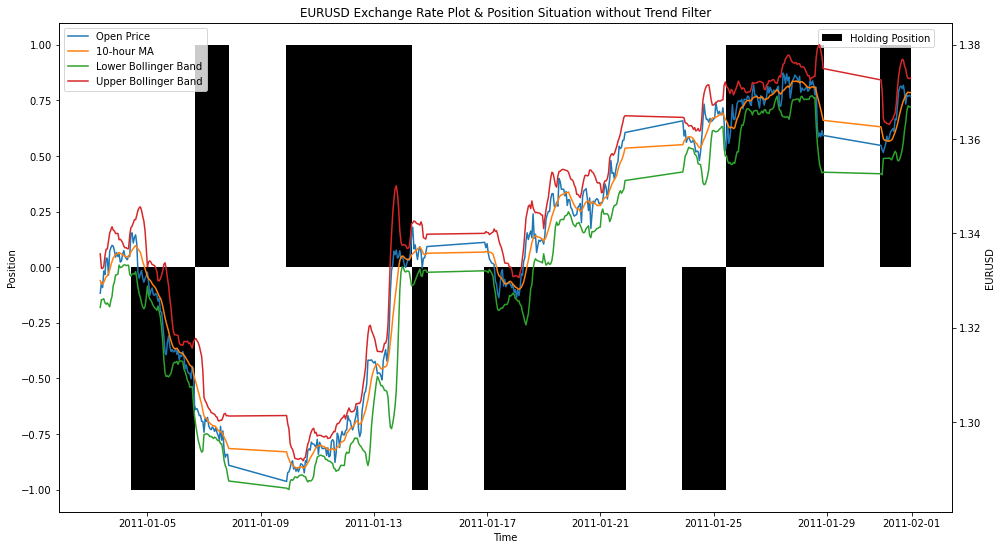

In [203]:
fig, ax1 = plt.subplots(figsize=(16,9))
ax2 = ax1.twinx()
ax1.bar(eu_table1['Gmt time'].values[1:], eu_table1['holding'].values[1:], label='Holding Position',color='black',width=0.05)
ax2.plot(eu_table1['Gmt time'].values[1:], eu_table1['Open'].values[1:], label='Open Price')
ax2.plot(eu_table1['Gmt time'].values[1:], eu_table1['10_ma'].values[1:], label='10-hour MA')
ax2.plot(eu_table1['Gmt time'].values[1:], eu_table1['lower_bollinger_band'].values[1:], label='Lower Bollinger Band')
ax2.plot(eu_table1['Gmt time'].values[1:], eu_table1['upper_bollinger_band'].values[1:], label='Upper Bollinger Band')
ax1.legend(loc=[0.85,0.95])
ax2.legend()
ax1.set_xlabel('Time')
ax1.set_ylabel('Position')
ax2.set_ylabel('EURUSD')
ax1.set_title("EURUSD Exchange Rate Plot & Position Situation without Trend Filter")

plt.show()

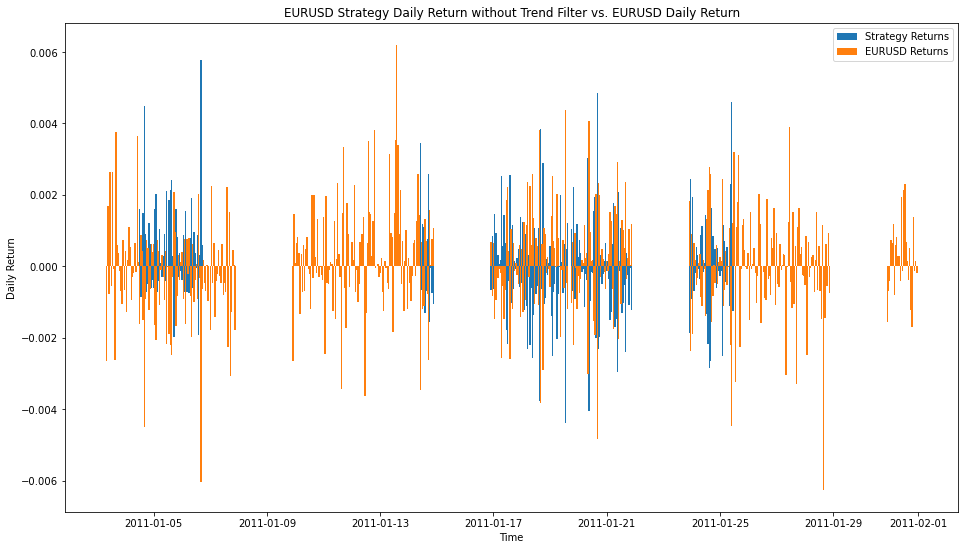

In [204]:
figure(figsize=(16,9))
plt.bar(eu_table1['Gmt time'].values[1:],eu_table1['strat_daily_ret'].values[1:],label='Strategy Returns',width=0.05)
plt.bar(eu_table1['Gmt time'].values[1:],eu_table1['fx_daily_ret'].values[1:],label='EURUSD Returns',width=0.05)
plt.xlabel("Time")
plt.ylabel("Daily Return")
plt.title("EURUSD Strategy Daily Return without Trend Filter vs. EURUSD Daily Return")
plt.legend()
plt.show()

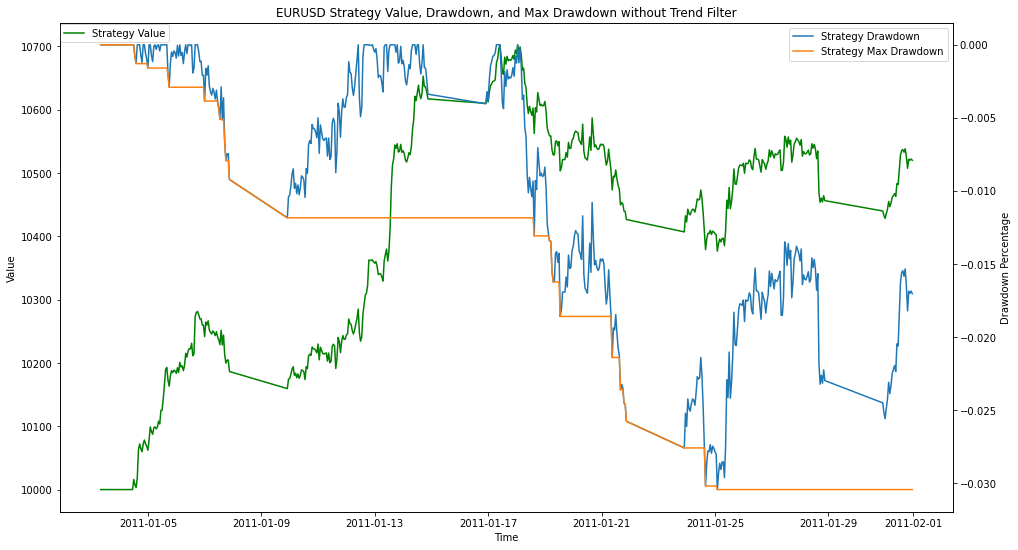

In [215]:
fig, ax1 = plt.subplots(figsize=(16,9))
ax2 = ax1.twinx()
ax1.plot(eu_table1['Gmt time'].values[1:], eu_table1['strat_value'].values[1:], label='Strategy Value',color='green')
ax2.plot(eu_table1['Gmt time'].values[1:], eu_table1['strat_drawdown'].values[1:], label='Strategy Drawdown')
ax2.plot(eu_table1['Gmt time'].values[1:], eu_table1['strat_max_drawdown'].values[1:], label='Strategy Max Drawdown')
ax1.legend(loc=[0,0.96])
ax2.legend()
ax1.set_xlabel('Time')
ax1.set_ylabel('Value')
ax2.set_ylabel('Drawdown Percentage')
ax1.set_title("EURUSD Strategy Value, Drawdown, and Max Drawdown without Trend Filter")

plt.show()

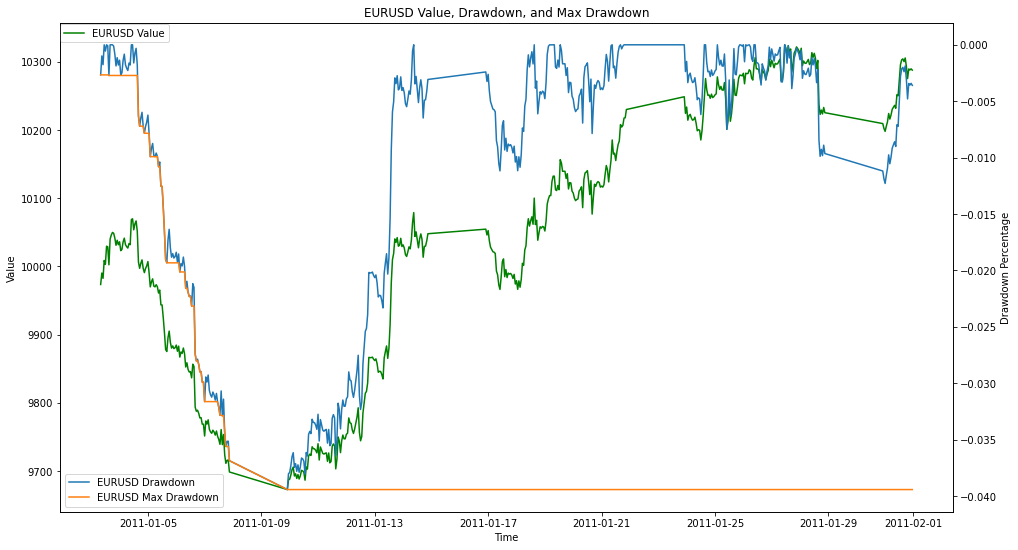

In [216]:
fig, ax1 = plt.subplots(figsize=(16,9))
ax2 = ax1.twinx()
ax1.plot(eu_table1['Gmt time'].values[1:], eu_table1['fx_value'].values[1:], label='EURUSD Value',color='green')
ax2.plot(eu_table1['Gmt time'].values[1:], eu_table1['fx_drawdown'].values[1:], label='EURUSD Drawdown')
ax2.plot(eu_table1['Gmt time'].values[1:], eu_table1['fx_max_drawdown'].values[1:], label='EURUSD Max Drawdown')
ax1.legend(loc=[0,0.96])
ax2.legend()
ax1.set_xlabel('Time')
ax1.set_ylabel('Value')
ax2.set_ylabel('Drawdown Percentage')
ax1.set_title("EURUSD Value, Drawdown, and Max Drawdown")

plt.show()

### EURUSD Bollinger Strategy with Trend Filter on Testing Data

In [217]:
eu_table2 = bollinger_strat_trend_filter(eu_test2, bollinger_period=20, short_ma=75, long_ma=175, thres=2)

eu_ret2 = (1+eu_table2['strat_cum_ret'].values[-1])**(6240/(len(eu_table2)-1))-1
eu_vol2 = np.std(eu_table2['strat_daily_ret'])*np.sqrt(6240)
eu_md2 = eu_table2['strat_max_drawdown'].values[-1]
eu_sharpe2 = eu_ret2/eu_vol2

fx_ret = (1+eu_table2['fx_cum_ret'].values[-1])**(6240/(len(eu_table2)-1))-1
fx_vol = np.std(eu_table2['fx_daily_ret'])*np.sqrt(6240)
fx_md = eu_table2['fx_max_drawdown'].values[-1]
fx_sharpe = fx_ret/fx_vol

eu_2 = {'Bollinger Strat with Trend Filter':[eu_ret2,eu_vol2,eu_md2,eu_sharpe2],
       'Buy-hold Strat':[fx_ret,fx_vol,fx_md,fx_sharpe]}
eu_2 = pd.DataFrame(eu_2)
eu_2.index = ['Annualized Return','Annualized Volatility','Max Drawdown','Sharpe Ratio']
eu_2

,Bollinger Strat with Trend Filter,Buy-hold Strat
Annualized Return,0.399911,1.643456
Annualized Volatility,0.113331,0.116551
Max Drawdown,-0.024574,-0.012268
Sharpe Ratio,3.528706,14.100724


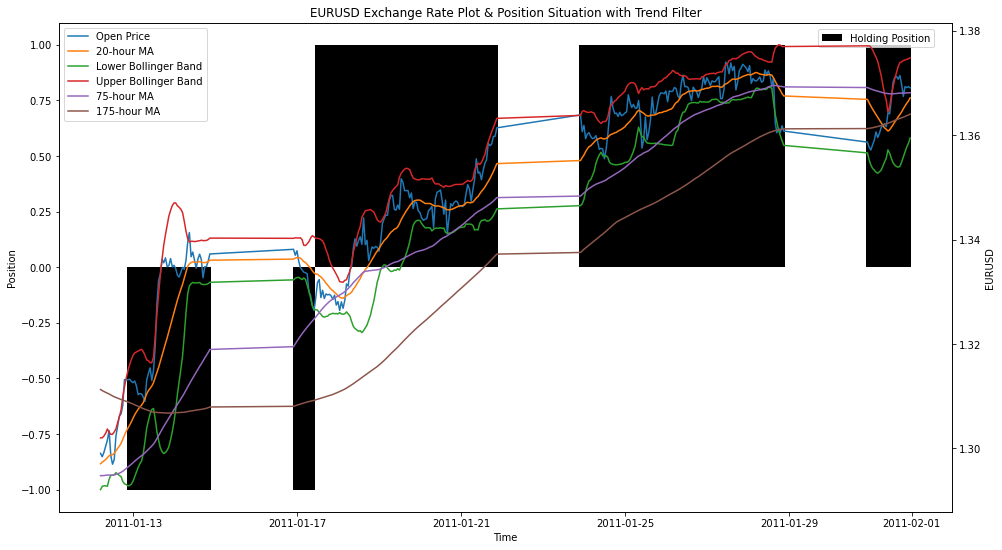

In [219]:
fig, ax1 = plt.subplots(figsize=(16,9))
ax2 = ax1.twinx()
ax1.bar(eu_table2['Gmt time'].values[1:], eu_table2['holding'].values[1:], label='Holding Position',color='black',width=0.05)
ax2.plot(eu_table2['Gmt time'].values[1:], eu_table2['Open'].values[1:], label='Open Price')
ax2.plot(eu_table2['Gmt time'].values[1:], eu_table2['20_ma'].values[1:], label='20-hour MA')
ax2.plot(eu_table2['Gmt time'].values[1:], eu_table2['lower_bollinger_band'].values[1:], label='Lower Bollinger Band')
ax2.plot(eu_table2['Gmt time'].values[1:], eu_table2['upper_bollinger_band'].values[1:], label='Upper Bollinger Band')
ax2.plot(eu_table2['Gmt time'].values[1:], eu_table2['75_ma'].values[1:], label='75-hour MA')
ax2.plot(eu_table2['Gmt time'].values[1:], eu_table2['175_ma'].values[1:], label='175-hour MA')
ax1.legend(loc=[0.85,0.95])
ax2.legend()
ax1.set_xlabel('Time')
ax1.set_ylabel('Position')
ax2.set_ylabel('EURUSD')
ax1.set_title("EURUSD Exchange Rate Plot & Position Situation with Trend Filter")

plt.show()

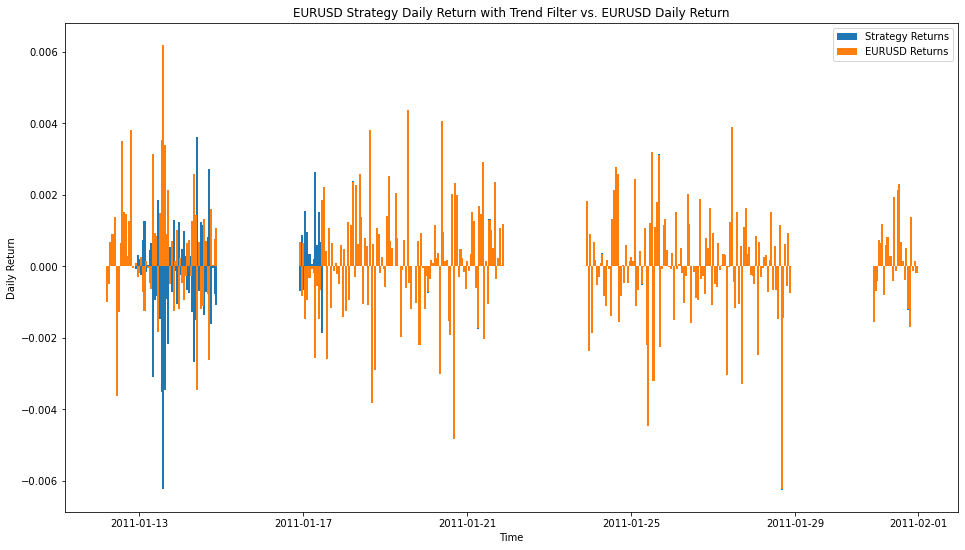

In [220]:
figure(figsize=(16,9))
plt.bar(eu_table2['Gmt time'].values[1:],eu_table2['strat_daily_ret'].values[1:],label='Strategy Returns',width=0.05)
plt.bar(eu_table2['Gmt time'].values[1:],eu_table2['fx_daily_ret'].values[1:],label='EURUSD Returns',width=0.05)
plt.xlabel("Time")
plt.ylabel("Daily Return")
plt.title("EURUSD Strategy Daily Return with Trend Filter vs. EURUSD Daily Return")
plt.legend()
plt.show()

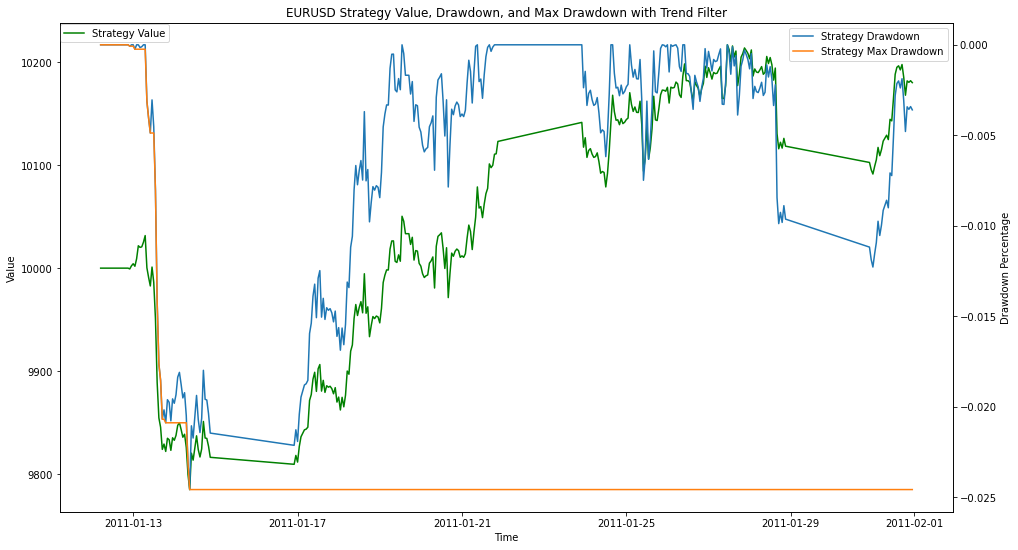

In [221]:
fig, ax1 = plt.subplots(figsize=(16,9))
ax2 = ax1.twinx()
ax1.plot(eu_table2['Gmt time'].values[1:], eu_table2['strat_value'].values[1:], label='Strategy Value',color='green')
ax2.plot(eu_table2['Gmt time'].values[1:], eu_table2['strat_drawdown'].values[1:], label='Strategy Drawdown')
ax2.plot(eu_table2['Gmt time'].values[1:], eu_table2['strat_max_drawdown'].values[1:], label='Strategy Max Drawdown')
ax1.legend(loc=[0,0.96])
ax2.legend()
ax1.set_xlabel('Time')
ax1.set_ylabel('Value')
ax2.set_ylabel('Drawdown Percentage')
ax1.set_title("EURUSD Strategy Value, Drawdown, and Max Drawdown with Trend Filter")

plt.show()

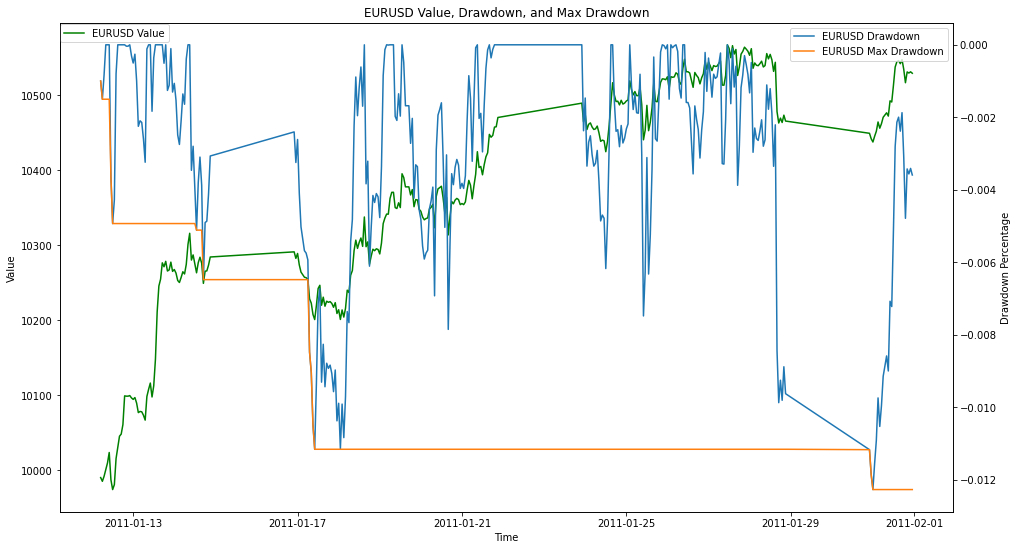

In [222]:
fig, ax1 = plt.subplots(figsize=(16,9))
ax2 = ax1.twinx()
ax1.plot(eu_table2['Gmt time'].values[1:], eu_table2['fx_value'].values[1:], label='EURUSD Value',color='green')
ax2.plot(eu_table2['Gmt time'].values[1:], eu_table2['fx_drawdown'].values[1:], label='EURUSD Drawdown')
ax2.plot(eu_table2['Gmt time'].values[1:], eu_table2['fx_max_drawdown'].values[1:], label='EURUSD Max Drawdown')
ax1.legend(loc=[0,0.96])
ax2.legend()
ax1.set_xlabel('Time')
ax1.set_ylabel('Value')
ax2.set_ylabel('Drawdown Percentage')
ax1.set_title("EURUSD Value, Drawdown, and Max Drawdown")

plt.show()

### GBPUSD Bollinger Strategy w/o Trend Filter on Testing Data

In [223]:
gu_table1 = bollinger_strat(gu_test1, bollinger_period=15, thres=2)

gu_ret1 = (1+gu_table1['strat_cum_ret'].values[-1])**(6240/(len(gu_table1)-1))-1
gu_vol1 = np.std(gu_table1['strat_daily_ret'])*np.sqrt(6240)
gu_md1 = gu_table1['strat_max_drawdown'].values[-1]
gu_sharpe1 = gu_ret1/gu_vol1

fx_ret = (1+gu_table1['fx_cum_ret'].values[-1])**(6240/(len(gu_table1)-1))-1
fx_vol = np.std(gu_table1['fx_daily_ret'])*np.sqrt(6240)
fx_md = gu_table1['fx_max_drawdown'].values[-1]
fx_sharpe = fx_ret/fx_vol

gu_1 = {'Bollinger Strat w/o Trend Filter':[gu_ret1,gu_vol1,gu_md1,gu_sharpe1],
       'Buy-hold Strat':[fx_ret,fx_vol,fx_md,fx_sharpe]}
gu_1 = pd.DataFrame(gu_1)
gu_1.index = ['Annualized Return','Annualized Volatility','Max Drawdown','Sharpe Ratio']
gu_1

,Bollinger Strat w/o Trend Filter,Buy-hold Strat
Annualized Return,0.465260,0.553746
Annualized Volatility,0.098082,0.101817
Max Drawdown,-0.021871,-0.018048
Sharpe Ratio,4.743602,5.438645


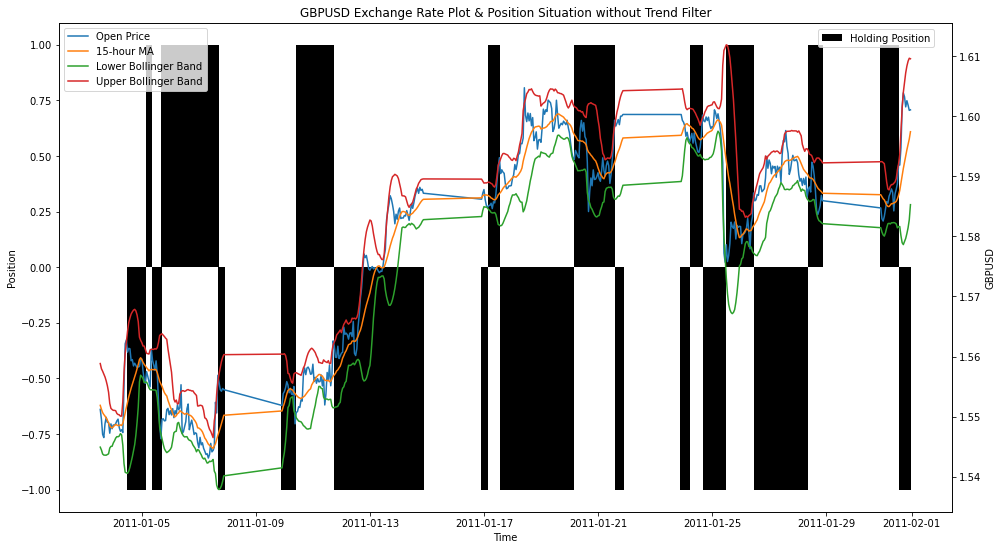

In [224]:
fig, ax1 = plt.subplots(figsize=(16,9))
ax2 = ax1.twinx()
ax1.bar(gu_table1['Gmt time'].values[1:], gu_table1['holding'].values[1:], label='Holding Position',color='black',width=0.05)
ax2.plot(gu_table1['Gmt time'].values[1:], gu_table1['Open'].values[1:], label='Open Price')
ax2.plot(gu_table1['Gmt time'].values[1:], gu_table1['15_ma'].values[1:], label='15-hour MA')
ax2.plot(gu_table1['Gmt time'].values[1:], gu_table1['lower_bollinger_band'].values[1:], label='Lower Bollinger Band')
ax2.plot(gu_table1['Gmt time'].values[1:], gu_table1['upper_bollinger_band'].values[1:], label='Upper Bollinger Band')
ax1.legend(loc=[0.85,0.95])
ax2.legend()
ax1.set_xlabel('Time')
ax1.set_ylabel('Position')
ax2.set_ylabel('GBPUSD')
ax1.set_title("GBPUSD Exchange Rate Plot & Position Situation without Trend Filter")

plt.show()

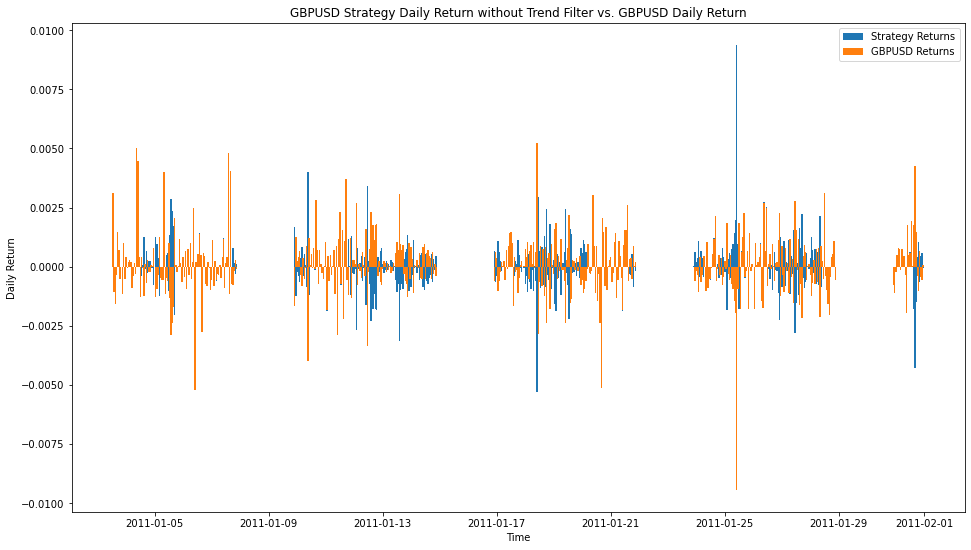

In [225]:
figure(figsize=(16,9))
plt.bar(gu_table1['Gmt time'].values[1:],gu_table1['strat_daily_ret'].values[1:],label='Strategy Returns',width=0.05)
plt.bar(gu_table1['Gmt time'].values[1:],gu_table1['fx_daily_ret'].values[1:],label='GBPUSD Returns',width=0.05)
plt.xlabel("Time")
plt.ylabel("Daily Return")
plt.title("GBPUSD Strategy Daily Return without Trend Filter vs. GBPUSD Daily Return")
plt.legend()
plt.show()

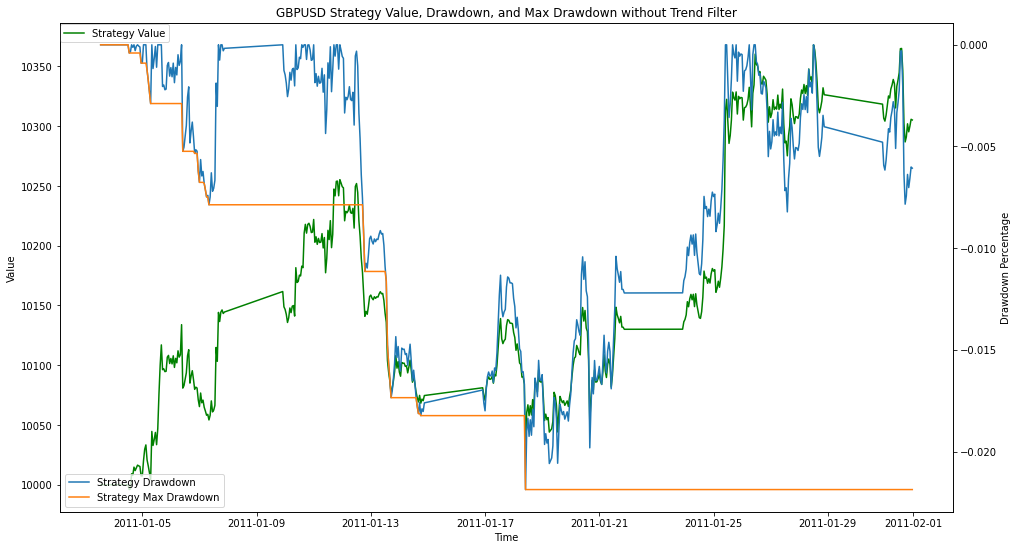

In [226]:
fig, ax1 = plt.subplots(figsize=(16,9))
ax2 = ax1.twinx()
ax1.plot(gu_table1['Gmt time'].values[1:], gu_table1['strat_value'].values[1:], label='Strategy Value',color='green')
ax2.plot(gu_table1['Gmt time'].values[1:], gu_table1['strat_drawdown'].values[1:], label='Strategy Drawdown')
ax2.plot(gu_table1['Gmt time'].values[1:], gu_table1['strat_max_drawdown'].values[1:], label='Strategy Max Drawdown')
ax1.legend(loc=[0,0.96])
ax2.legend()
ax1.set_xlabel('Time')
ax1.set_ylabel('Value')
ax2.set_ylabel('Drawdown Percentage')
ax1.set_title("GBPUSD Strategy Value, Drawdown, and Max Drawdown without Trend Filter")

plt.show()

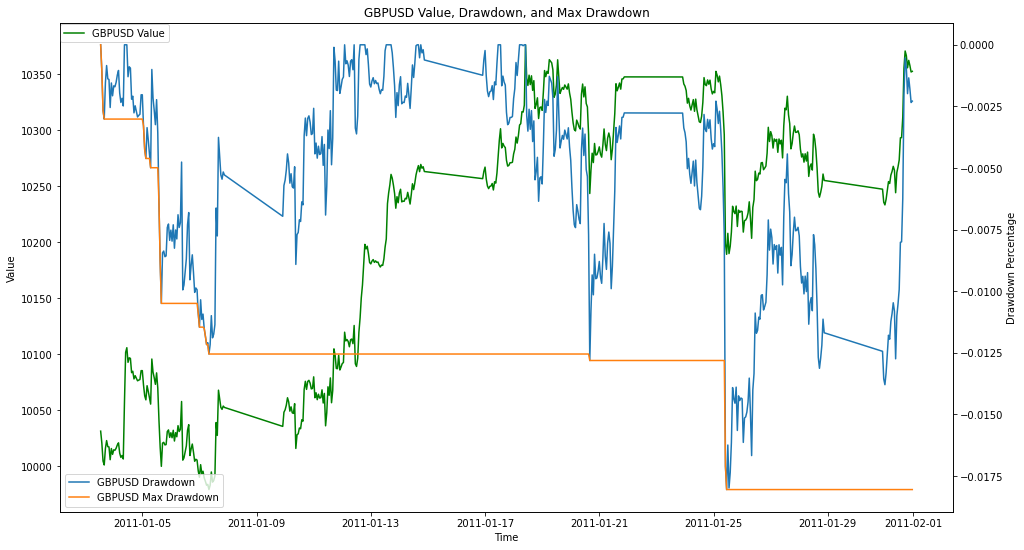

In [227]:
fig, ax1 = plt.subplots(figsize=(16,9))
ax2 = ax1.twinx()
ax1.plot(gu_table1['Gmt time'].values[1:], gu_table1['fx_value'].values[1:], label='GBPUSD Value',color='green')
ax2.plot(gu_table1['Gmt time'].values[1:], gu_table1['fx_drawdown'].values[1:], label='GBPUSD Drawdown')
ax2.plot(gu_table1['Gmt time'].values[1:], gu_table1['fx_max_drawdown'].values[1:], label='GBPUSD Max Drawdown')
ax1.legend(loc=[0,0.96])
ax2.legend()
ax1.set_xlabel('Time')
ax1.set_ylabel('Value')
ax2.set_ylabel('Drawdown Percentage')
ax1.set_title("GBPUSD Value, Drawdown, and Max Drawdown")

plt.show()

### GBPUSD Bollinger Strategy with Trend Filter on Testing Data

In [228]:
gu_table2 = bollinger_strat_trend_filter(gu_test2, bollinger_period=15, short_ma=75, long_ma=175, thres=2)

gu_ret2 = (1+gu_table2['strat_cum_ret'].values[-1])**(6240/(len(gu_table2)-1))-1
gu_vol2 = np.std(gu_table2['strat_daily_ret'])*np.sqrt(6240)
gu_md2 = gu_table2['strat_max_drawdown'].values[-1]
gu_sharpe2 = gu_ret2/gu_vol2

fx_ret = (1+gu_table2['fx_cum_ret'].values[-1])**(6240/(len(gu_table2)-1))-1
fx_vol = np.std(gu_table2['fx_daily_ret'])*np.sqrt(6240)
fx_md = gu_table2['fx_max_drawdown'].values[-1]
fx_sharpe = fx_ret/fx_vol

gu_2 = {'Bollinger Strat with Trend Filter':[gu_ret2,gu_vol2,gu_md2,gu_sharpe2],
       'Buy-hold Strat':[fx_ret,fx_vol,fx_md,fx_sharpe]}
gu_2 = pd.DataFrame(gu_2)
gu_2.index = ['Annualized Return','Annualized Volatility','Max Drawdown','Sharpe Ratio']
gu_2

,Bollinger Strat with Trend Filter,Buy-hold Strat
Annualized Return,-0.157880,0.557585
Annualized Volatility,0.092110,0.097960
Max Drawdown,-0.022954,-0.018105
Sharpe Ratio,-1.714052,5.691934


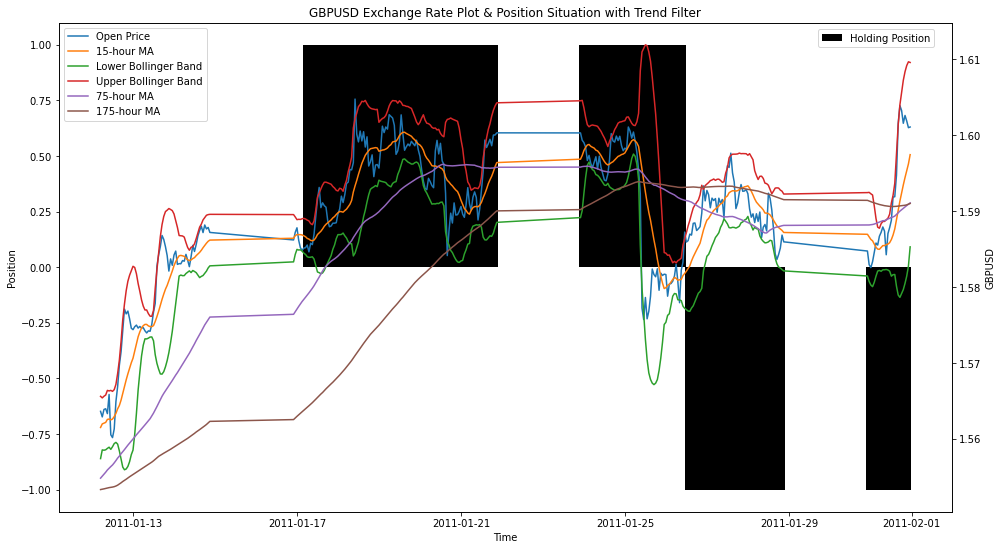

In [231]:
fig, ax1 = plt.subplots(figsize=(16,9))
ax2 = ax1.twinx()
ax1.bar(gu_table2['Gmt time'].values[1:], gu_table2['holding'].values[1:], label='Holding Position',color='black',width=0.05)
ax2.plot(gu_table2['Gmt time'].values[1:], gu_table2['Open'].values[1:], label='Open Price')
ax2.plot(gu_table2['Gmt time'].values[1:], gu_table2['15_ma'].values[1:], label='15-hour MA')
ax2.plot(gu_table2['Gmt time'].values[1:], gu_table2['lower_bollinger_band'].values[1:], label='Lower Bollinger Band')
ax2.plot(gu_table2['Gmt time'].values[1:], gu_table2['upper_bollinger_band'].values[1:], label='Upper Bollinger Band')
ax2.plot(gu_table2['Gmt time'].values[1:], gu_table2['75_ma'].values[1:], label='75-hour MA')
ax2.plot(gu_table2['Gmt time'].values[1:], gu_table2['175_ma'].values[1:], label='175-hour MA')
ax1.legend(loc=[0.85,0.95])
ax2.legend()
ax1.set_xlabel('Time')
ax1.set_ylabel('Position')
ax2.set_ylabel('GBPUSD')
ax1.set_title("GBPUSD Exchange Rate Plot & Position Situation with Trend Filter")

plt.show()

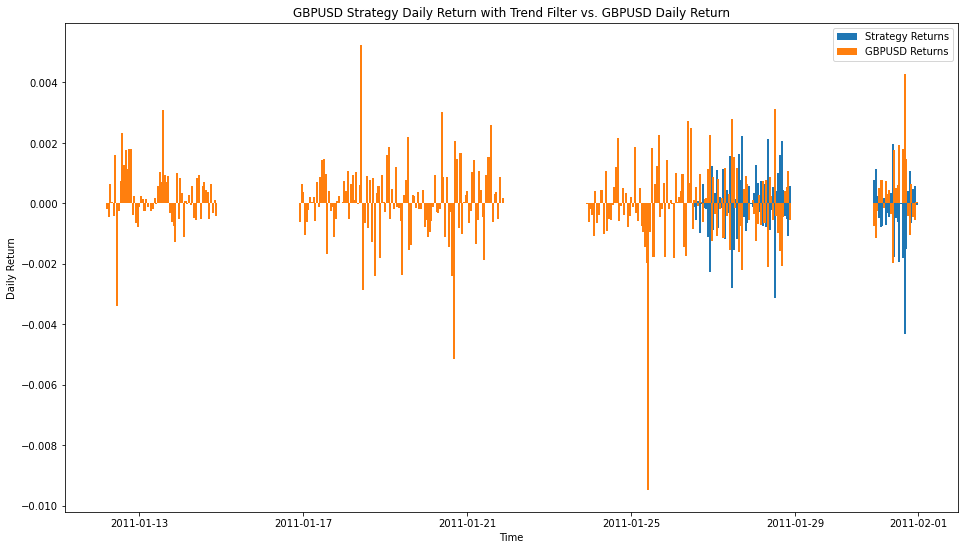

In [232]:
figure(figsize=(16,9))
plt.bar(gu_table2['Gmt time'].values[1:],gu_table2['strat_daily_ret'].values[1:],label='Strategy Returns',width=0.05)
plt.bar(gu_table2['Gmt time'].values[1:],gu_table2['fx_daily_ret'].values[1:],label='GBPUSD Returns',width=0.05)
plt.xlabel("Time")
plt.ylabel("Daily Return")
plt.title("GBPUSD Strategy Daily Return with Trend Filter vs. GBPUSD Daily Return")
plt.legend()
plt.show()

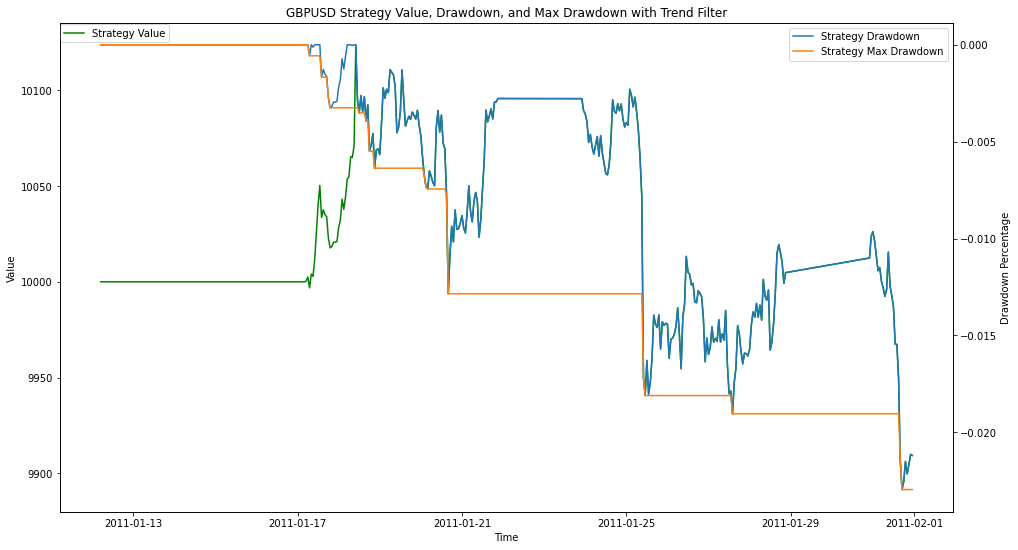

In [233]:
fig, ax1 = plt.subplots(figsize=(16,9))
ax2 = ax1.twinx()
ax1.plot(gu_table2['Gmt time'].values[1:], gu_table2['strat_value'].values[1:], label='Strategy Value',color='green')
ax2.plot(gu_table2['Gmt time'].values[1:], gu_table2['strat_drawdown'].values[1:], label='Strategy Drawdown')
ax2.plot(gu_table2['Gmt time'].values[1:], gu_table2['strat_max_drawdown'].values[1:], label='Strategy Max Drawdown')
ax1.legend(loc=[0,0.96])
ax2.legend()
ax1.set_xlabel('Time')
ax1.set_ylabel('Value')
ax2.set_ylabel('Drawdown Percentage')
ax1.set_title("GBPUSD Strategy Value, Drawdown, and Max Drawdown with Trend Filter")

plt.show()

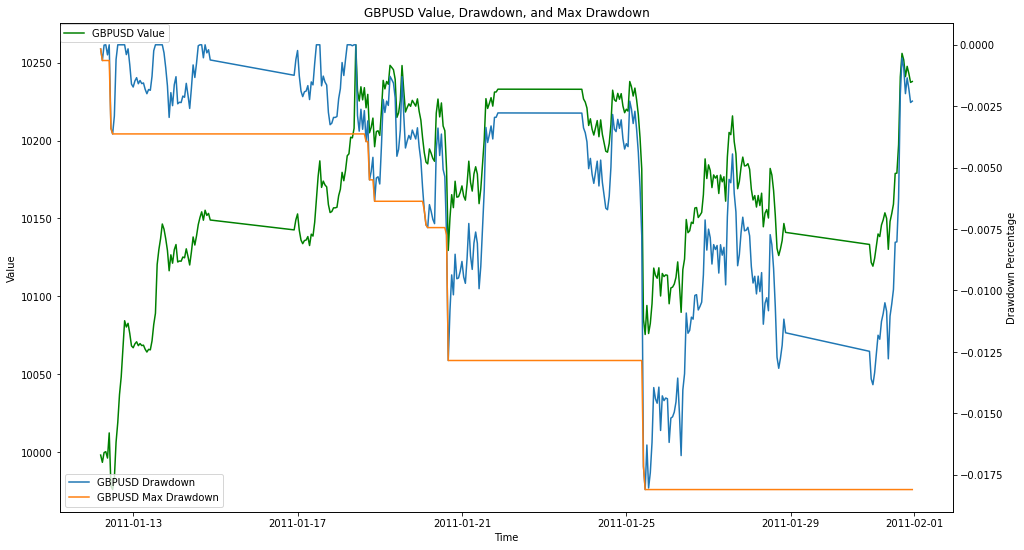

In [234]:
fig, ax1 = plt.subplots(figsize=(16,9))
ax2 = ax1.twinx()
ax1.plot(gu_table2['Gmt time'].values[1:], gu_table2['fx_value'].values[1:], label='GBPUSD Value',color='green')
ax2.plot(gu_table2['Gmt time'].values[1:], gu_table2['fx_drawdown'].values[1:], label='GBPUSD Drawdown')
ax2.plot(gu_table2['Gmt time'].values[1:], gu_table2['fx_max_drawdown'].values[1:], label='GBPUSD Max Drawdown')
ax1.legend(loc=[0,0.96])
ax2.legend()
ax1.set_xlabel('Time')
ax1.set_ylabel('Value')
ax2.set_ylabel('Drawdown Percentage')
ax1.set_title("GBPUSD Value, Drawdown, and Max Drawdown")

plt.show()

### USDCHF Bollinger Strategy w/o Trend Filter on Testing Data

In [235]:
uc_table1 = bollinger_strat(uc_test1, bollinger_period=10, thres=2)

uc_ret1 = (1+uc_table1['strat_cum_ret'].values[-1])**(6240/(len(uc_table1)-1))-1
uc_vol1 = np.std(uc_table1['strat_daily_ret'])*np.sqrt(6240)
uc_md1 = uc_table1['strat_max_drawdown'].values[-1]
uc_sharpe1 = uc_ret1/uc_vol1

fx_ret = (1+uc_table1['fx_cum_ret'].values[-1])**(6240/(len(uc_table1)-1))-1
fx_vol = np.std(uc_table1['fx_daily_ret'])*np.sqrt(6240)
fx_md = uc_table1['fx_max_drawdown'].values[-1]
fx_sharpe = fx_ret/fx_vol

uc_1 = {'Bollinger Strat w/o Trend Filter':[uc_ret1,uc_vol1,uc_md1,uc_sharpe1],
       'Buy-hold Strat':[fx_ret,fx_vol,fx_md,fx_sharpe]}
uc_1 = pd.DataFrame(uc_1)
uc_1.index = ['Annualized Return','Annualized Volatility','Max Drawdown','Sharpe Ratio']
uc_1

,Bollinger Strat w/o Trend Filter,Buy-hold Strat
Annualized Return,-0.268941,0.129319
Annualized Volatility,0.117376,0.116635
Max Drawdown,-0.039764,-0.037787
Sharpe Ratio,-2.291273,1.108754


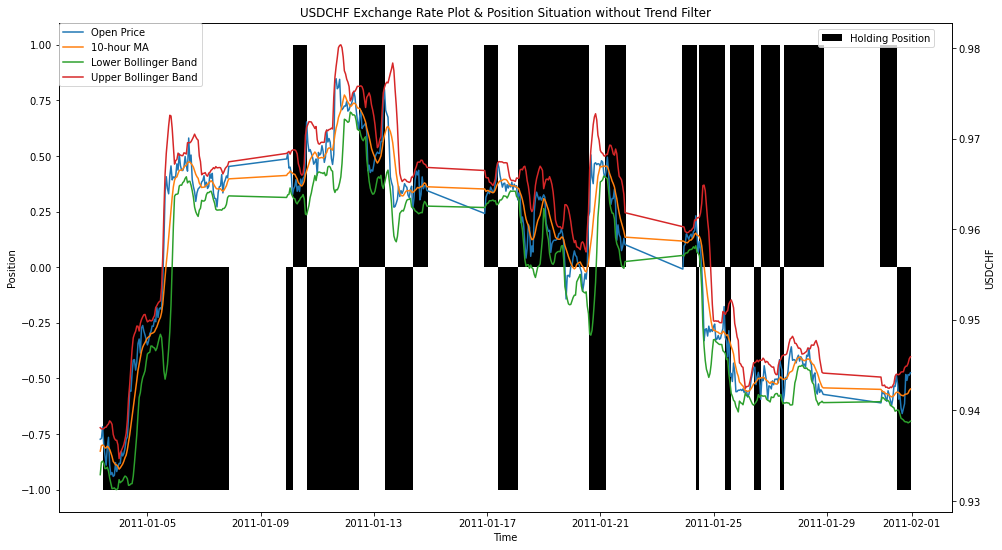

In [252]:
fig, ax1 = plt.subplots(figsize=(16,9))
ax2 = ax1.twinx()
ax1.bar(uc_table1['Gmt time'].values[1:], uc_table1['holding'].values[1:], label='Holding Position',color='black',width=0.05)
ax2.plot(uc_table1['Gmt time'].values[1:], uc_table1['Open'].values[1:], label='Open Price')
ax2.plot(uc_table1['Gmt time'].values[1:], uc_table1['10_ma'].values[1:], label='10-hour MA')
ax2.plot(uc_table1['Gmt time'].values[1:], uc_table1['lower_bollinger_band'].values[1:], label='Lower Bollinger Band')
ax2.plot(uc_table1['Gmt time'].values[1:], uc_table1['upper_bollinger_band'].values[1:], label='Upper Bollinger Band')
ax1.legend(loc=[0.85,0.95])
ax2.legend(loc=[0,0.87])
ax1.set_xlabel('Time')
ax1.set_ylabel('Position')
ax2.set_ylabel('USDCHF')
ax1.set_title("USDCHF Exchange Rate Plot & Position Situation without Trend Filter")

plt.show()

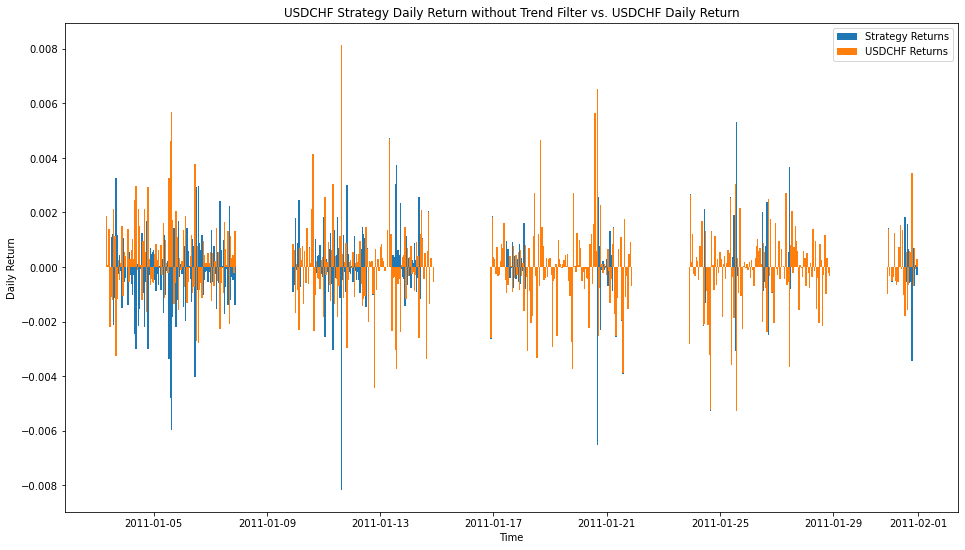

In [237]:
figure(figsize=(16,9))
plt.bar(uc_table1['Gmt time'].values[1:],uc_table1['strat_daily_ret'].values[1:],label='Strategy Returns',width=0.05)
plt.bar(uc_table1['Gmt time'].values[1:],uc_table1['fx_daily_ret'].values[1:],label='USDCHF Returns',width=0.05)
plt.xlabel("Time")
plt.ylabel("Daily Return")
plt.title("USDCHF Strategy Daily Return without Trend Filter vs. USDCHF Daily Return")
plt.legend()
plt.show()

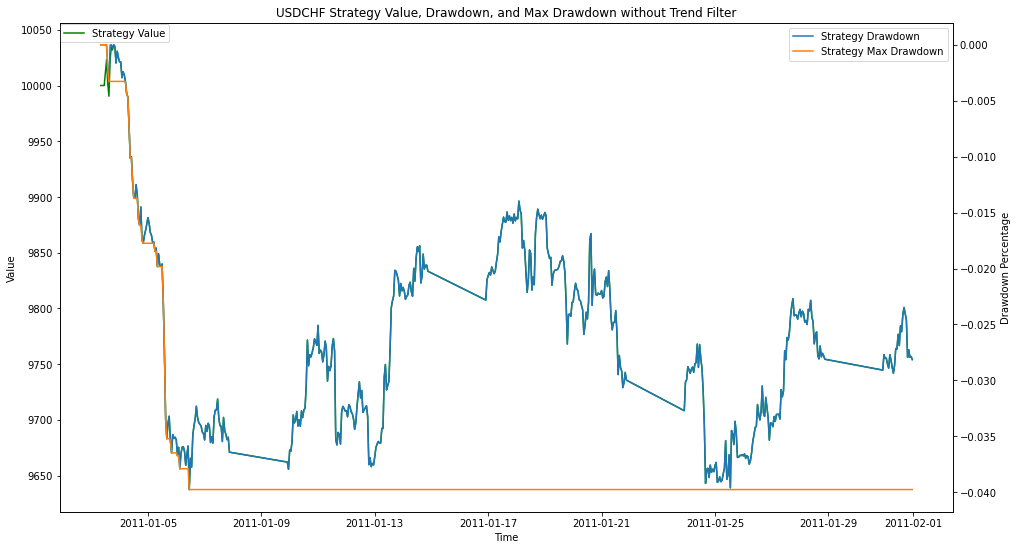

In [238]:
fig, ax1 = plt.subplots(figsize=(16,9))
ax2 = ax1.twinx()
ax1.plot(uc_table1['Gmt time'].values[1:], uc_table1['strat_value'].values[1:], label='Strategy Value',color='green')
ax2.plot(uc_table1['Gmt time'].values[1:], uc_table1['strat_drawdown'].values[1:], label='Strategy Drawdown')
ax2.plot(uc_table1['Gmt time'].values[1:], uc_table1['strat_max_drawdown'].values[1:], label='Strategy Max Drawdown')
ax1.legend(loc=[0,0.96])
ax2.legend()
ax1.set_xlabel('Time')
ax1.set_ylabel('Value')
ax2.set_ylabel('Drawdown Percentage')
ax1.set_title("USDCHF Strategy Value, Drawdown, and Max Drawdown without Trend Filter")

plt.show()

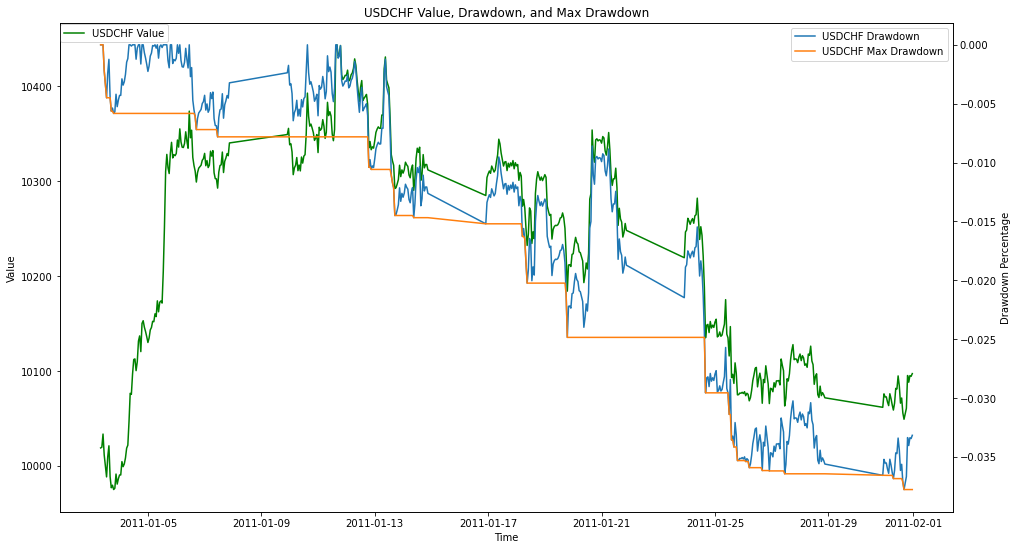

In [239]:
fig, ax1 = plt.subplots(figsize=(16,9))
ax2 = ax1.twinx()
ax1.plot(uc_table1['Gmt time'].values[1:], uc_table1['fx_value'].values[1:], label='USDCHF Value',color='green')
ax2.plot(uc_table1['Gmt time'].values[1:], uc_table1['fx_drawdown'].values[1:], label='USDCHF Drawdown')
ax2.plot(uc_table1['Gmt time'].values[1:], uc_table1['fx_max_drawdown'].values[1:], label='USDCHF Max Drawdown')
ax1.legend(loc=[0,0.96])
ax2.legend()
ax1.set_xlabel('Time')
ax1.set_ylabel('Value')
ax2.set_ylabel('Drawdown Percentage')
ax1.set_title("USDCHF Value, Drawdown, and Max Drawdown")

plt.show()

### USDCHF Bollinger Strategy with Trend Filter on Testing Data

In [240]:
uc_table2 = bollinger_strat_trend_filter(uc_test2, bollinger_period=10, short_ma=75, long_ma=200, thres=1.5)

uc_ret2 = (1+uc_table2['strat_cum_ret'].values[-1])**(6240/(len(uc_table2)-1))-1
uc_vol2 = np.std(uc_table2['strat_daily_ret'])*np.sqrt(6240)
uc_md2 = uc_table2['strat_max_drawdown'].values[-1]
uc_sharpe2 = uc_ret2/uc_vol2

fx_ret = (1+uc_table2['fx_cum_ret'].values[-1])**(6240/(len(uc_table2)-1))-1
fx_vol = np.std(uc_table2['fx_daily_ret'])*np.sqrt(6240)
fx_md = uc_table2['fx_max_drawdown'].values[-1]
fx_sharpe = fx_ret/fx_vol

uc_2 = {'Bollinger Strat with Trend Filter':[uc_ret2,uc_vol2,uc_md2,uc_sharpe2],
       'Buy-hold Strat':[fx_ret,fx_vol,fx_md,fx_sharpe]}
uc_2 = pd.DataFrame(uc_2)
uc_2.index = ['Annualized Return','Annualized Volatility','Max Drawdown','Sharpe Ratio']
uc_2

,Bollinger Strat with Trend Filter,Buy-hold Strat
Annualized Return,0.469381,-0.402980
Annualized Volatility,0.108955,0.115489
Max Drawdown,-0.016326,-0.036622
Sharpe Ratio,4.308018,-3.489334


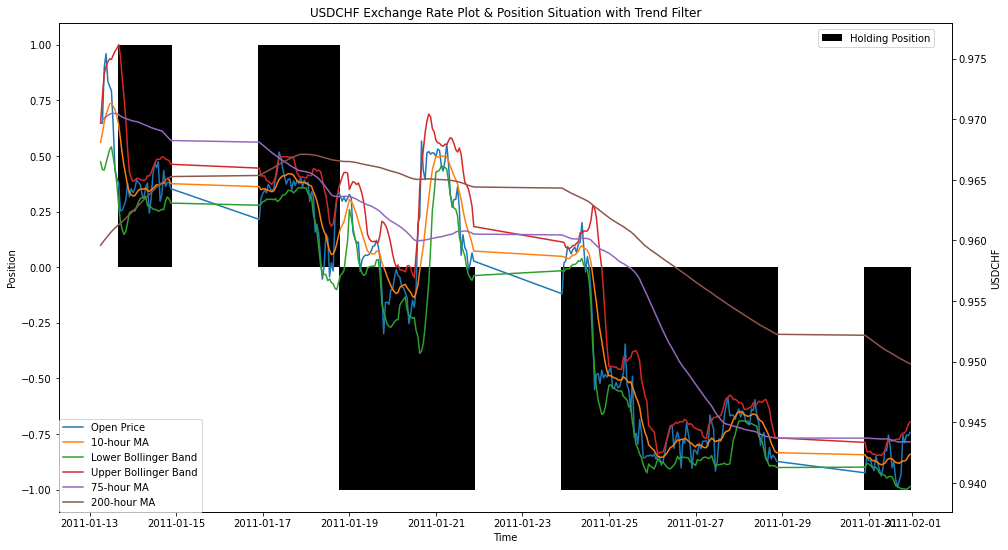

In [259]:
fig, ax1 = plt.subplots(figsize=(16,9))
ax2 = ax1.twinx()
ax1.bar(uc_table2['Gmt time'].values[1:], uc_table2['holding'].values[1:], label='Holding Position',color='black',width=0.05)
ax2.plot(uc_table2['Gmt time'].values[1:], uc_table2['Open'].values[1:], label='Open Price')
ax2.plot(uc_table2['Gmt time'].values[1:], uc_table2['10_ma'].values[1:], label='10-hour MA')
ax2.plot(uc_table2['Gmt time'].values[1:], uc_table2['lower_bollinger_band'].values[1:], label='Lower Bollinger Band')
ax2.plot(uc_table2['Gmt time'].values[1:], uc_table2['upper_bollinger_band'].values[1:], label='Upper Bollinger Band')
ax2.plot(uc_table2['Gmt time'].values[1:], uc_table2['75_ma'].values[1:], label='75-hour MA')
ax2.plot(uc_table2['Gmt time'].values[1:], uc_table2['200_ma'].values[1:], label='200-hour MA')
ax1.legend(loc=[0.85,0.95])
ax2.legend(loc=[0,0])
ax1.set_xlabel('Time')
ax1.set_ylabel('Position')
ax2.set_ylabel('USDCHF')
ax1.set_title("USDCHF Exchange Rate Plot & Position Situation with Trend Filter")

plt.show()

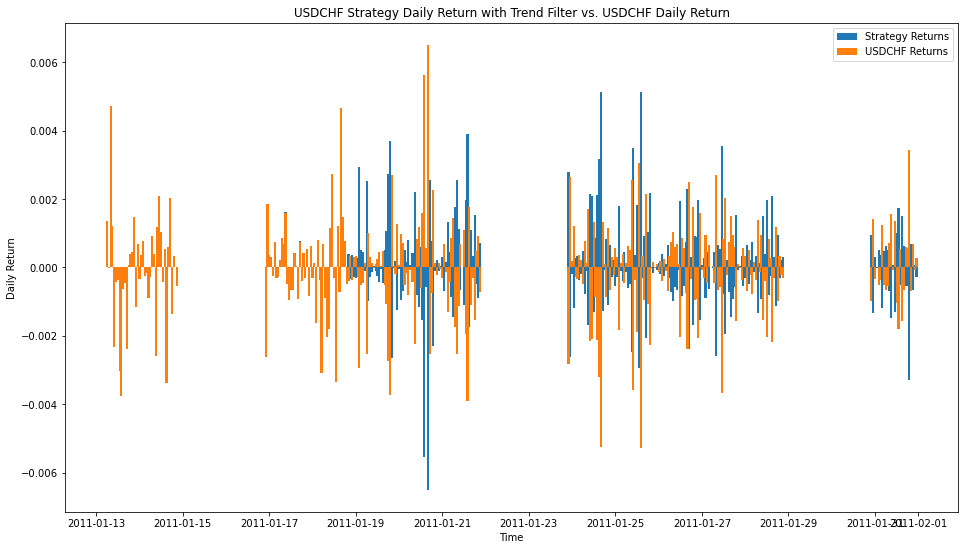

In [242]:
figure(figsize=(16,9))
plt.bar(uc_table2['Gmt time'].values[1:],uc_table2['strat_daily_ret'].values[1:],label='Strategy Returns',width=0.05)
plt.bar(uc_table2['Gmt time'].values[1:],uc_table2['fx_daily_ret'].values[1:],label='USDCHF Returns',width=0.05)
plt.xlabel("Time")
plt.ylabel("Daily Return")
plt.title("USDCHF Strategy Daily Return with Trend Filter vs. USDCHF Daily Return")
plt.legend()
plt.show()

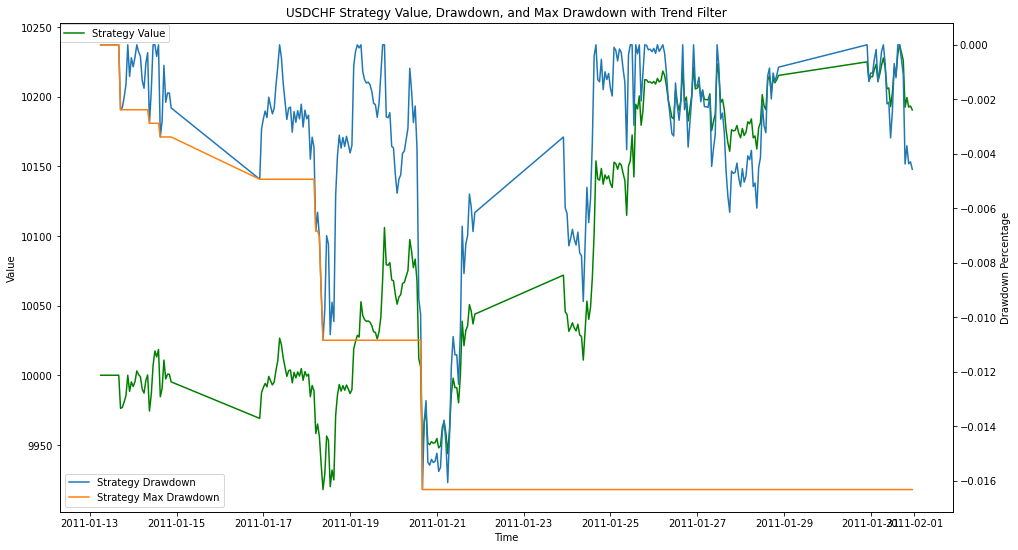

In [243]:
fig, ax1 = plt.subplots(figsize=(16,9))
ax2 = ax1.twinx()
ax1.plot(uc_table2['Gmt time'].values[1:], uc_table2['strat_value'].values[1:], label='Strategy Value',color='green')
ax2.plot(uc_table2['Gmt time'].values[1:], uc_table2['strat_drawdown'].values[1:], label='Strategy Drawdown')
ax2.plot(uc_table2['Gmt time'].values[1:], uc_table2['strat_max_drawdown'].values[1:], label='Strategy Max Drawdown')
ax1.legend(loc=[0,0.96])
ax2.legend()
ax1.set_xlabel('Time')
ax1.set_ylabel('Value')
ax2.set_ylabel('Drawdown Percentage')
ax1.set_title("USDCHF Strategy Value, Drawdown, and Max Drawdown with Trend Filter")

plt.show()

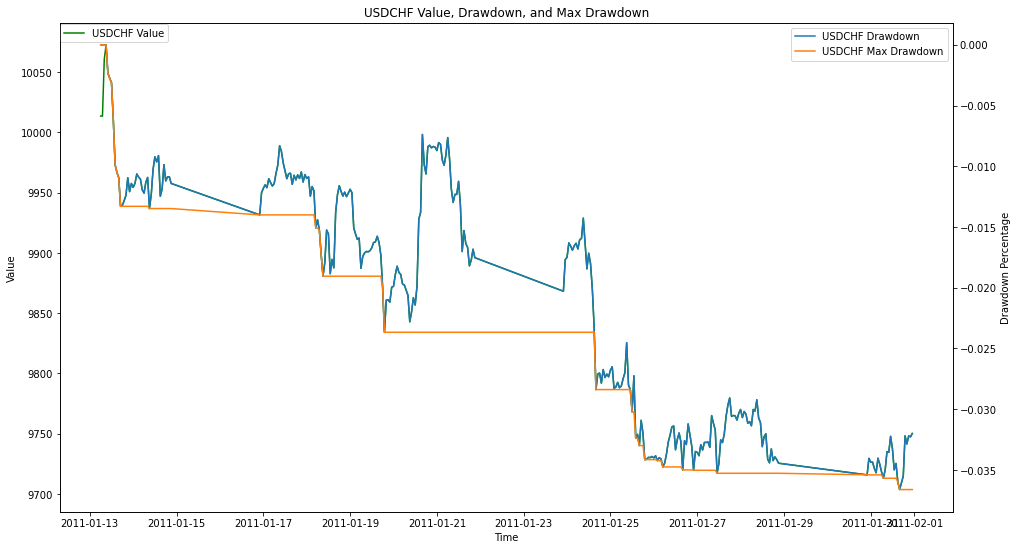

In [244]:
fig, ax1 = plt.subplots(figsize=(16,9))
ax2 = ax1.twinx()
ax1.plot(uc_table2['Gmt time'].values[1:], uc_table2['fx_value'].values[1:], label='USDCHF Value',color='green')
ax2.plot(uc_table2['Gmt time'].values[1:], uc_table2['fx_drawdown'].values[1:], label='USDCHF Drawdown')
ax2.plot(uc_table2['Gmt time'].values[1:], uc_table2['fx_max_drawdown'].values[1:], label='USDCHF Max Drawdown')
ax1.legend(loc=[0,0.96])
ax2.legend()
ax1.set_xlabel('Time')
ax1.set_ylabel('Value')
ax2.set_ylabel('Drawdown Percentage')
ax1.set_title("USDCHF Value, Drawdown, and Max Drawdown")

plt.show()

### USDJPY Bollinger Strategy w/o Trend Filter on Testing Data

In [245]:
uj_table1 = bollinger_strat(uj_test1, bollinger_period=20, thres=2)

uj_ret1 = (1+uj_table1['strat_cum_ret'].values[-1])**(6240/(len(uj_table1)-1))-1
uj_vol1 = np.std(uj_table1['strat_daily_ret'])*np.sqrt(6240)
uj_md1 = uj_table1['strat_max_drawdown'].values[-1]
uj_sharpe1 = uj_ret1/uj_vol1

fx_ret = (1+uj_table1['fx_cum_ret'].values[-1])**(6240/(len(uj_table1)-1))-1
fx_vol = np.std(uj_table1['fx_daily_ret'])*np.sqrt(6240)
fx_md = uj_table1['fx_max_drawdown'].values[-1]
fx_sharpe = fx_ret/fx_vol

uj_1 = {'Bollinger Strat w/o Trend Filter':[uj_ret1,uj_vol1,uj_md1,uj_sharpe1],
       'Buy-hold Strat':[fx_ret,fx_vol,fx_md,fx_sharpe]}
uj_1 = pd.DataFrame(uj_1)
uj_1.index = ['Annualized Return','Annualized Volatility','Max Drawdown','Sharpe Ratio']
uj_1

,Bollinger Strat w/o Trend Filter,Buy-hold Strat
Annualized Return,-0.060605,0.080636
Annualized Volatility,0.098575,0.099005
Max Drawdown,-0.019186,-0.020243
Sharpe Ratio,-0.614816,0.814469


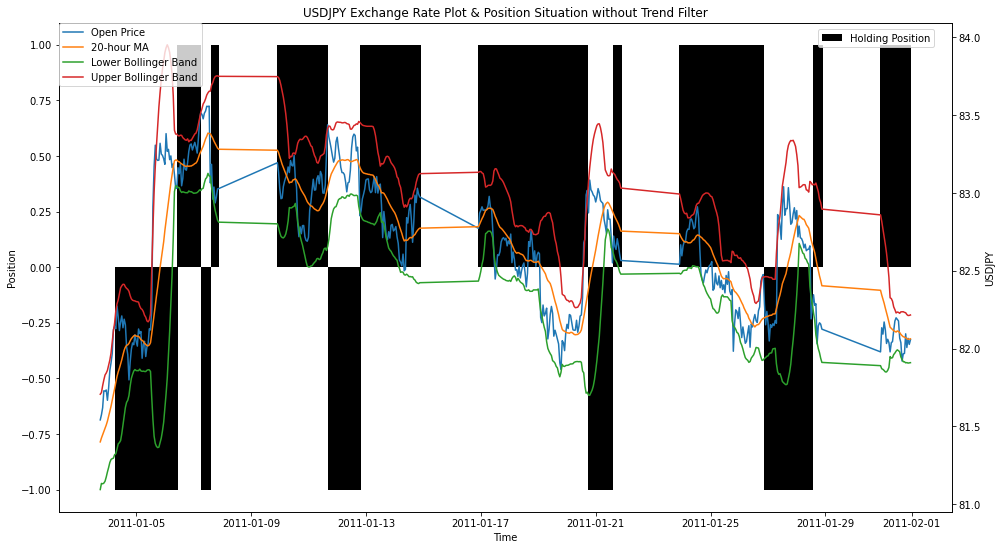

In [260]:
fig, ax1 = plt.subplots(figsize=(16,9))
ax2 = ax1.twinx()
ax1.bar(uj_table1['Gmt time'].values[1:], uj_table1['holding'].values[1:], label='Holding Position',color='black',width=0.05)
ax2.plot(uj_table1['Gmt time'].values[1:], uj_table1['Open'].values[1:], label='Open Price')
ax2.plot(uj_table1['Gmt time'].values[1:], uj_table1['20_ma'].values[1:], label='20-hour MA')
ax2.plot(uj_table1['Gmt time'].values[1:], uj_table1['lower_bollinger_band'].values[1:], label='Lower Bollinger Band')
ax2.plot(uj_table1['Gmt time'].values[1:], uj_table1['upper_bollinger_band'].values[1:], label='Upper Bollinger Band')
ax1.legend(loc=[0.85,0.95])
ax2.legend(loc=[0,0.87])
ax1.set_xlabel('Time')
ax1.set_ylabel('Position')
ax2.set_ylabel('USDJPY')
ax1.set_title("USDJPY Exchange Rate Plot & Position Situation without Trend Filter")

plt.show()

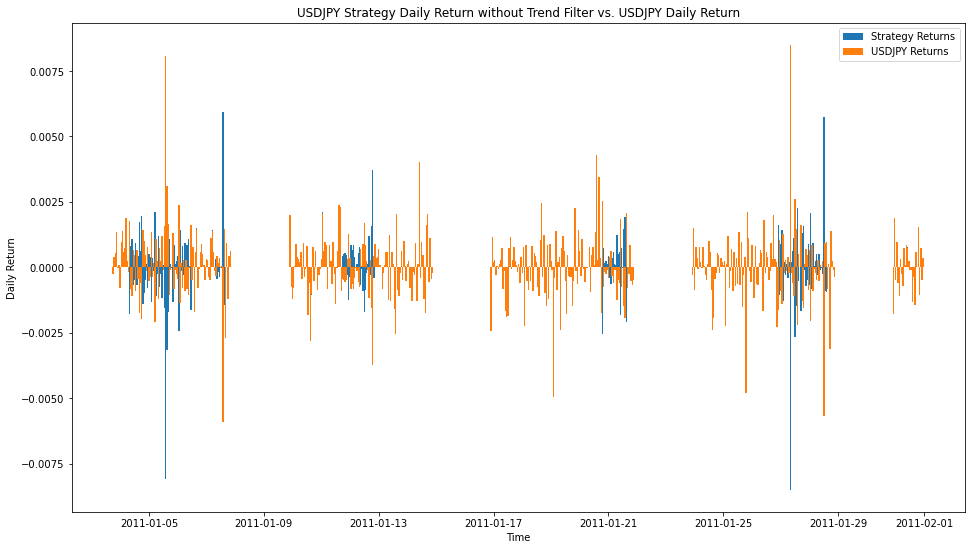

In [247]:
figure(figsize=(16,9))
plt.bar(uj_table1['Gmt time'].values[1:],uj_table1['strat_daily_ret'].values[1:],label='Strategy Returns',width=0.05)
plt.bar(uj_table1['Gmt time'].values[1:],uj_table1['fx_daily_ret'].values[1:],label='USDJPY Returns',width=0.05)
plt.xlabel("Time")
plt.ylabel("Daily Return")
plt.title("USDJPY Strategy Daily Return without Trend Filter vs. USDJPY Daily Return")
plt.legend()
plt.show()

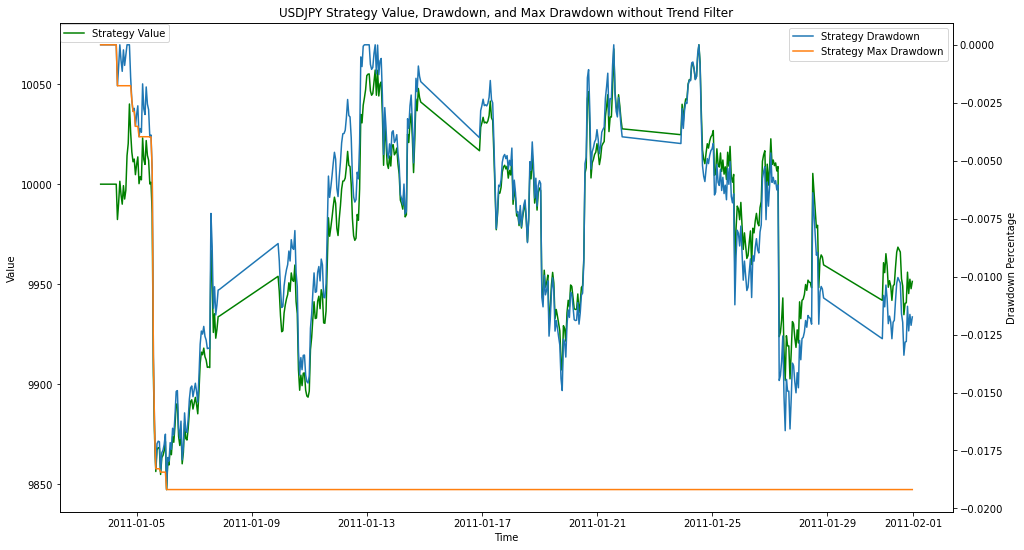

In [261]:
fig, ax1 = plt.subplots(figsize=(16,9))
ax2 = ax1.twinx()
ax1.plot(uj_table1['Gmt time'].values[1:], uj_table1['strat_value'].values[1:], label='Strategy Value',color='green')
ax2.plot(uj_table1['Gmt time'].values[1:], uj_table1['strat_drawdown'].values[1:], label='Strategy Drawdown')
ax2.plot(uj_table1['Gmt time'].values[1:], uj_table1['strat_max_drawdown'].values[1:], label='Strategy Max Drawdown')
ax1.legend(loc=[0,0.96])
ax2.legend()
ax1.set_xlabel('Time')
ax1.set_ylabel('Value')
ax2.set_ylabel('Drawdown Percentage')
ax1.set_title("USDJPY Strategy Value, Drawdown, and Max Drawdown without Trend Filter")

plt.show()

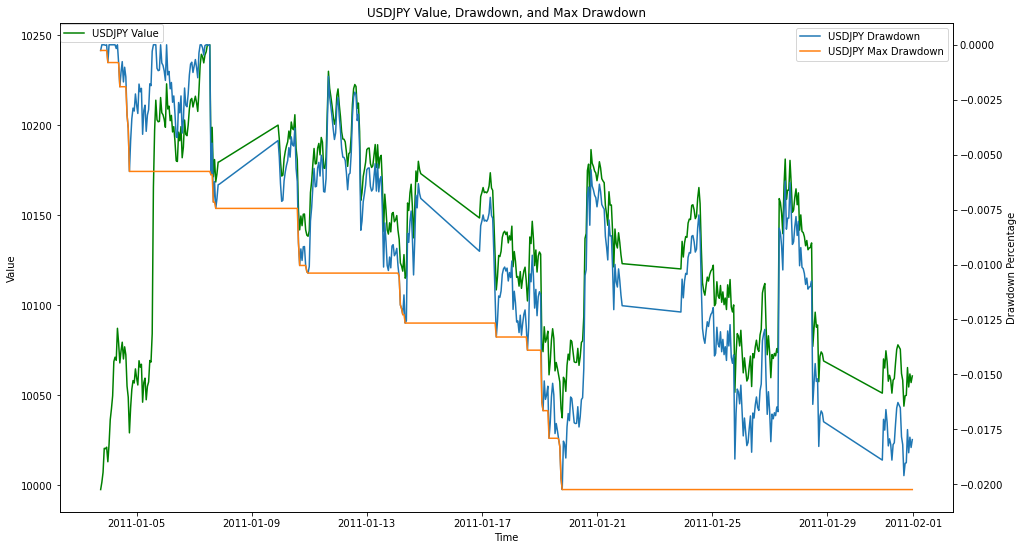

In [262]:
fig, ax1 = plt.subplots(figsize=(16,9))
ax2 = ax1.twinx()
ax1.plot(uj_table1['Gmt time'].values[1:], uj_table1['fx_value'].values[1:], label='USDJPY Value',color='green')
ax2.plot(uj_table1['Gmt time'].values[1:], uj_table1['fx_drawdown'].values[1:], label='USDJPY Drawdown')
ax2.plot(uj_table1['Gmt time'].values[1:], uj_table1['fx_max_drawdown'].values[1:], label='USDJPY Max Drawdown')
ax1.legend(loc=[0,0.96])
ax2.legend()
ax1.set_xlabel('Time')
ax1.set_ylabel('Value')
ax2.set_ylabel('Drawdown Percentage')
ax1.set_title("USDJPY Value, Drawdown, and Max Drawdown")

plt.show()

### USDJPY Bollinger Strategy with Trend Filter on Testing Data

In [263]:
uj_table2 = bollinger_strat_trend_filter(uj_test2, bollinger_period=25, short_ma=75, long_ma=175, thres=1.5)

uj_ret2 = (1+uj_table2['strat_cum_ret'].values[-1])**(6240/(len(uj_table2)-1))-1
uj_vol2 = np.std(uj_table2['strat_daily_ret'])*np.sqrt(6240)
uj_md2 = uj_table2['strat_max_drawdown'].values[-1]
uj_sharpe2 = uj_ret2/uj_vol2

fx_ret = (1+uj_table2['fx_cum_ret'].values[-1])**(6240/(len(uj_table2)-1))-1
fx_vol = np.std(uj_table2['fx_daily_ret'])*np.sqrt(6240)
fx_md = uj_table2['fx_max_drawdown'].values[-1]
fx_sharpe = fx_ret/fx_vol

uj_2 = {'Bollinger Strat with Trend Filter':[uj_ret2,uj_vol2,uj_md2,uj_sharpe2],
       'Buy-hold Strat':[fx_ret,fx_vol,fx_md,fx_sharpe]}
uj_2 = pd.DataFrame(uj_2)
uj_2.index = ['Annualized Return','Annualized Volatility','Max Drawdown','Sharpe Ratio']
uj_2

,Bollinger Strat with Trend Filter,Buy-hold Strat
Annualized Return,0.104980,-0.217409
Annualized Volatility,0.095882,0.098280
Max Drawdown,-0.016476,-0.018123
Sharpe Ratio,1.094885,-2.212146


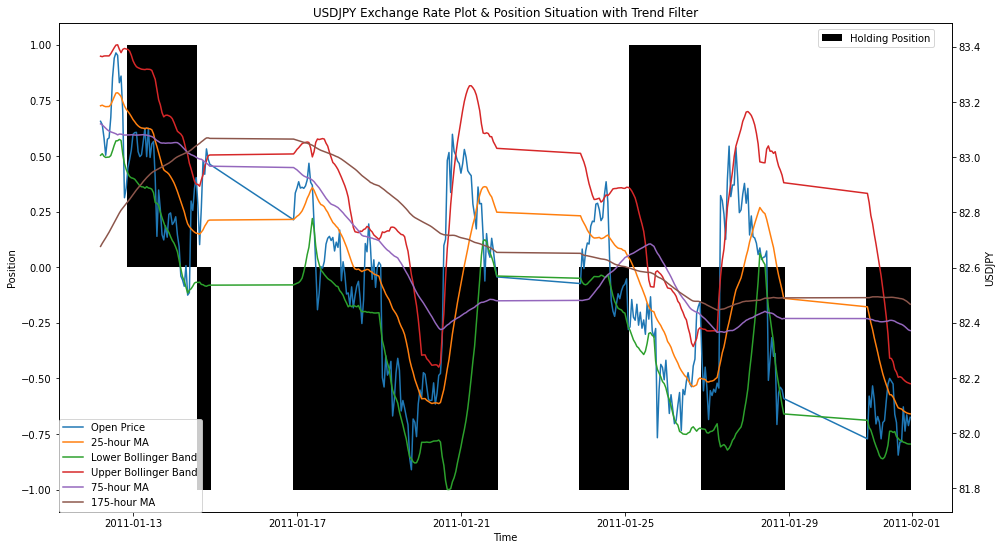

In [265]:
fig, ax1 = plt.subplots(figsize=(16,9))
ax2 = ax1.twinx()
ax1.bar(uj_table2['Gmt time'].values[1:], uj_table2['holding'].values[1:], label='Holding Position',color='black',width=0.05)
ax2.plot(uj_table2['Gmt time'].values[1:], uj_table2['Open'].values[1:], label='Open Price')
ax2.plot(uj_table2['Gmt time'].values[1:], uj_table2['25_ma'].values[1:], label='25-hour MA')
ax2.plot(uj_table2['Gmt time'].values[1:], uj_table2['lower_bollinger_band'].values[1:], label='Lower Bollinger Band')
ax2.plot(uj_table2['Gmt time'].values[1:], uj_table2['upper_bollinger_band'].values[1:], label='Upper Bollinger Band')
ax2.plot(uj_table2['Gmt time'].values[1:], uj_table2['75_ma'].values[1:], label='75-hour MA')
ax2.plot(uj_table2['Gmt time'].values[1:], uj_table2['175_ma'].values[1:], label='175-hour MA')
ax1.legend(loc=[0.85,0.95])
ax2.legend(loc=[0,0])
ax1.set_xlabel('Time')
ax1.set_ylabel('Position')
ax2.set_ylabel('USDJPY')
ax1.set_title("USDJPY Exchange Rate Plot & Position Situation with Trend Filter")

plt.show()

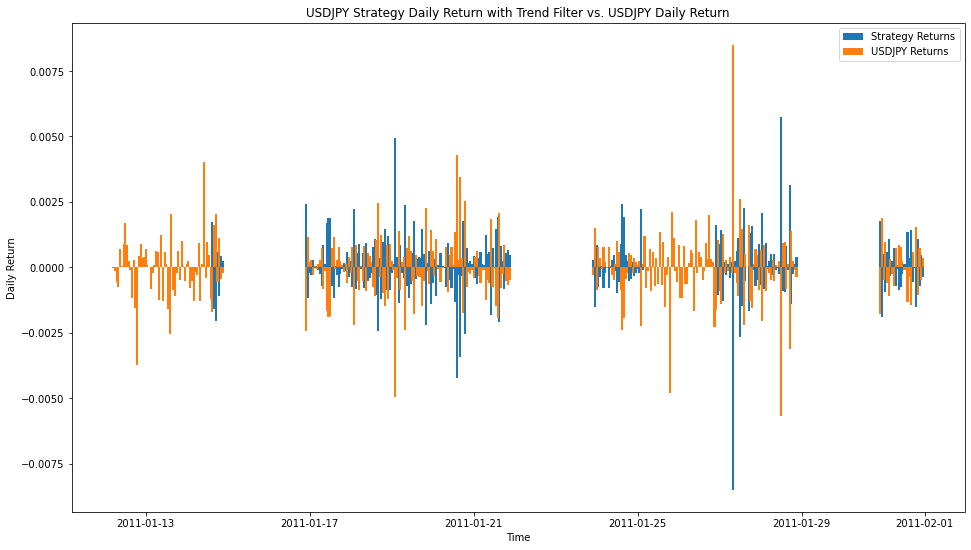

In [266]:
figure(figsize=(16,9))
plt.bar(uj_table2['Gmt time'].values[1:],uj_table2['strat_daily_ret'].values[1:],label='Strategy Returns',width=0.05)
plt.bar(uj_table2['Gmt time'].values[1:],uj_table2['fx_daily_ret'].values[1:],label='USDJPY Returns',width=0.05)
plt.xlabel("Time")
plt.ylabel("Daily Return")
plt.title("USDJPY Strategy Daily Return with Trend Filter vs. USDJPY Daily Return")
plt.legend()
plt.show()

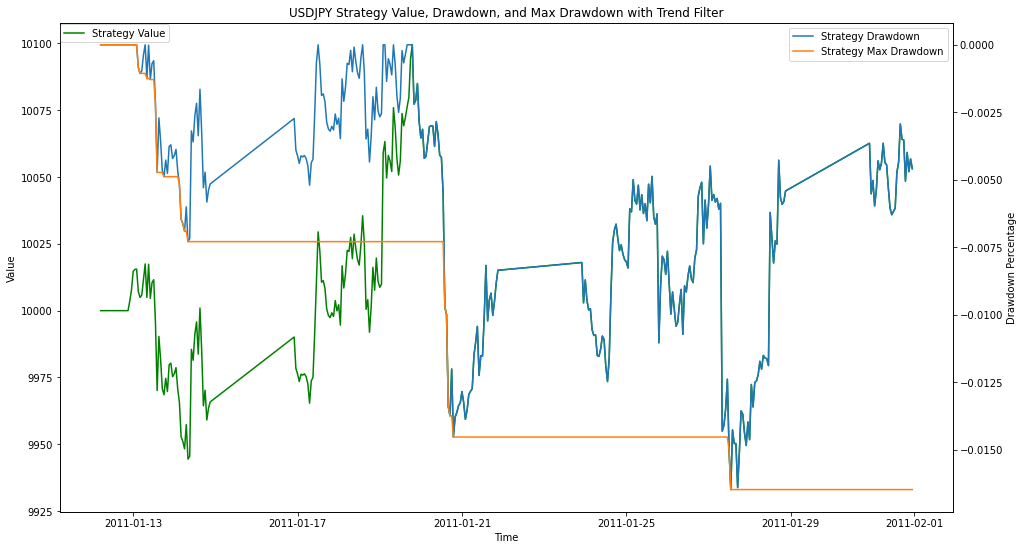

In [267]:
fig, ax1 = plt.subplots(figsize=(16,9))
ax2 = ax1.twinx()
ax1.plot(uj_table2['Gmt time'].values[1:], uj_table2['strat_value'].values[1:], label='Strategy Value',color='green')
ax2.plot(uj_table2['Gmt time'].values[1:], uj_table2['strat_drawdown'].values[1:], label='Strategy Drawdown')
ax2.plot(uj_table2['Gmt time'].values[1:], uj_table2['strat_max_drawdown'].values[1:], label='Strategy Max Drawdown')
ax1.legend(loc=[0,0.96])
ax2.legend()
ax1.set_xlabel('Time')
ax1.set_ylabel('Value')
ax2.set_ylabel('Drawdown Percentage')
ax1.set_title("USDJPY Strategy Value, Drawdown, and Max Drawdown with Trend Filter")

plt.show()

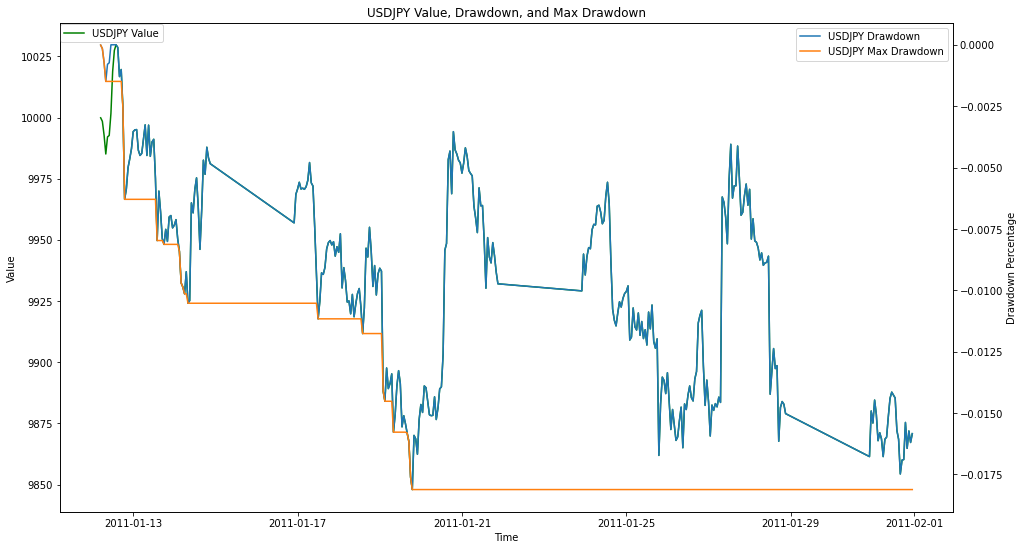

In [268]:
fig, ax1 = plt.subplots(figsize=(16,9))
ax2 = ax1.twinx()
ax1.plot(uj_table2['Gmt time'].values[1:], uj_table2['fx_value'].values[1:], label='USDJPY Value',color='green')
ax2.plot(uj_table2['Gmt time'].values[1:], uj_table2['fx_drawdown'].values[1:], label='USDJPY Drawdown')
ax2.plot(uj_table2['Gmt time'].values[1:], uj_table2['fx_max_drawdown'].values[1:], label='USDJPY Max Drawdown')
ax1.legend(loc=[0,0.96])
ax2.legend()
ax1.set_xlabel('Time')
ax1.set_ylabel('Value')
ax2.set_ylabel('Drawdown Percentage')
ax1.set_title("USDJPY Value, Drawdown, and Max Drawdown")

plt.show()